# Introduction

In this notebook, we introduce our Transfer Learning Neyman-Pearson algorithm. Our setup also provides implementation of various naive approaches used for comparison.

After, we provide implementation of the algorithm and naive approaches on the following datasets:
- Gaussian generated data
- ClimSim climate data (prediction of heavy rain and heavy snow events)
- Give Me Some Credit data (prediction of loan delinquency)
- NASA climate data (prediction of heavy rain events)

# Setup

## Import Statements

In [4]:
# Import libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.preprocessing import StandardScaler
import json
import time
import pandas as pd
from scipy.spatial import ConvexHull, Delaunay
from tabulate import tabulate
import copy
from pathlib import Path
from torch.utils.data import DataLoader, TensorDataset
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.optimize import minimize
import warnings
from glob import glob
import seaborn as sns
from scipy.stats import multivariate_normal, multivariate_t, norm
import math
import random
import torch.nn.init as init
import traceback
import os
import gc

### Connect to Local Drive (Optional)

In [89]:
import os
import platform
if platform.system() == 'Windows':
    root_drive_path = r'H:/My Drive/LEAP_NP_Project'
elif platform.system() == 'Darwin':  # 'Darwin' is the system name for macOS and iOS
    root_drive_path = os.path.expanduser(r'~/Google Drive/My Drive/LEAP_NP_Project')
else:
    raise OSError("Unsupported operating system")
if os.path.exists(root_drive_path):
    os.chdir(root_drive_path)
    print("Working directory changed to:", root_drive_path)
else:
    print("Path does not exist:", root_drive_path)

Working directory changed to: H:/My Drive/LEAP_NP_Project


## Model Definitions

TLNP is a model-agnostic framework. Our algorithm is compatible with any model that makes a binary prediction. Here, we provide examples using a Quadratic Form Model (used on the generated data) and a Multilayer Perceptron (used on the real datasets).

In [6]:
class QuadraticFormModel(nn.Module):
    def __init__(self, input_dim):
        super(QuadraticFormModel, self).__init__()
        self.A = nn.Parameter(torch.zeros(input_dim, input_dim))
        self.v = nn.Parameter(torch.zeros(input_dim))
        self.b = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return torch.matmul(torch.matmul(x, self.A), x.t()).diag() + torch.matmul(self.v, x.t()) + self.b

class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(MultiLayerPerceptron, self).__init__()
        # Define the first layer (input to hidden)
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        # Define the second layer (hidden to output)
        self.layer2 = nn.Linear(hidden_dim, 1)
        # Define the activation function
        self.activation = nn.ReLU()

    def forward(self, x):
        # Pass input through the first layer
        x = self.layer1(x)
        # Apply the activation function
        x = self.activation(x)
        # Pass the result through the second layer
        x = self.layer2(x)
        return x

def get_model(config):
    model_name = config.get('model_name', None)
    input_dim = config.get('input_dim', 0)
    hidden_dim = config.get('hidden_dim', input_dim//2)

    if model_name == "QuadraticForm":
        return QuadraticFormModel(input_dim)
    elif model_name == "MultiLayerPerceptron":
        return MultiLayerPerceptron(input_dim, hidden_dim)
    else:
        raise ValueError(f"Unsupported model name: {model_name}")

## Loss Functions

Our loss functions use `lambda_target`, `lambda_source`, and `lambda_normal` as weights for the losses associated with each dataset target abnormal, source abnormal, and target normal.

Abnormal points are predicted as positive numbers (i.e., `sign==1`) and normal points are predicted as negative numbers (`sign==-1`).

`labels` is used to differentiate between the target normal (`label==0`), target abnormal (`label==1`), and source abnormal (`label==2`). This should not be confused with the prediction itself.

Losses are also normalized by the number of points in each group.

Here we implement three loss functions:
- Exponential Loss
- Logistic Loss
- Hinge Loss

In our experimentation, we use Exponential Loss. Exponents are clipped at 20 to prevent overflow.

In [7]:
def exponential_loss_function(y_pred, labels, lambda_target, lambda_source, lambda_normal, normalize_losses=False, clip_value=20):
    if y_pred.numel() == 0:
        return torch.tensor(0.0, device=y_pred.device)

    # Ensure y_pred is at least two-dimensional before applying the mask
    if y_pred.dim() == 1:
        y_pred = y_pred.unsqueeze(1)  # Add an extra dimension to make it compatible

    # Initialize the loss to zero
    loss = torch.tensor(0.0, device=y_pred.device)

    # Compute the loss for each label type
    for label_value, lambda_val in [(1, lambda_target), (2, lambda_source), (0, lambda_normal)]:
        mask = (labels == label_value)
        if mask.sum() > 0:
            y_true = torch.ones_like(y_pred[mask]) if label_value in [1, 2] else -torch.ones_like(y_pred[mask])
            exp_term = -y_true * y_pred[mask]
            exp_term = torch.clip(exp_term, max=clip_value)
            current_loss = torch.mean(lambda_val * torch.exp(exp_term))

            if normalize_losses:
                current_loss /= mask.sum()

            loss += current_loss

    return loss

def logistic_loss_function(y_pred, labels, lambda_target, lambda_source, lambda_normal, normalize_losses=False, clip_value=20):
    if y_pred.numel() == 0:
        return torch.tensor(0.0, device=y_pred.device)

    # Initialize the loss to zero
    loss = torch.tensor(0.0, device=y_pred.device)

    # Ensure y_pred is at least two-dimensional before applying the mask
    if y_pred.dim() == 1:
        y_pred = y_pred.unsqueeze(1)  # Add an extra dimension to make it compatible

    # Compute the loss for each label type
    for label_value, lambda_val in [(1, lambda_target), (2, lambda_source), (0, lambda_normal)]:
        mask = (labels == label_value)
        if mask.sum() > 0:
            y_true = torch.ones_like(y_pred[mask]) if label_value in [1, 2] else -torch.ones_like(y_pred[mask])
            exp_term = -y_true * y_pred[mask]
            exp_term = torch.clip(exp_term, max=clip_value)
            current_loss = torch.mean(lambda_val * torch.log(1 + torch.exp(exp_term)))

            if normalize_losses:
                current_loss /= mask.sum()

            loss += current_loss

    return loss

def hinge_loss_function(y_pred, labels, lambda_target, lambda_source, lambda_normal, normalize_losses=False):
    if y_pred.numel() == 0:
        return torch.tensor(0.0, device=y_pred.device)

    # Ensure y_pred is at least two-dimensional before applying the mask
    if y_pred.dim() == 1:
        y_pred = y_pred.unsqueeze(1)  # Add an extra dimension to make it compatible

    # Initialize the loss to zero
    loss = torch.tensor(0.0, device=y_pred.device)

    # Compute the loss for each label type
    for label_value, lambda_val in [(1, lambda_target), (2, lambda_source), (0, lambda_normal)]:
        mask = (labels == label_value)
        if mask.sum() > 0:
            y_true = torch.ones_like(y_pred[mask]) if label_value in [1, 2] else -torch.ones_like(y_pred[mask])
            hinge_term = torch.clamp(1 - y_true * y_pred[mask], min=0)
            current_loss = torch.mean(lambda_val * hinge_term)

            if normalize_losses:
                current_loss /= mask.sum()

            loss += current_loss

    return loss

def get_loss_function(loss_function_type):
    if loss_function_type == "ExponentialLoss":
        return exponential_loss_function
    elif loss_function_type == "LogisticLoss":
        return logistic_loss_function
    elif loss_function_type == "HingeLoss":
        return hinge_loss_function
    else:
        raise ValueError(f"Unknown loss function: {loss_function_type}")

## Optimizer and Scheduler Definitions

Any optimizer or scheduler can be used. In our experimentation, we use Adam and ReduceLROnPlateau.

In [8]:
def get_optimizer(optimizer_config, model_parameters):
    optimizer_name = optimizer_config['optimizer_name']
    optimizer_params = optimizer_config.get(optimizer_name, {})
    learning_rate = optimizer_params.get('learning_rate', 0.001)

    if optimizer_name == "SGD":
        return optim.SGD(model_parameters, lr=learning_rate, momentum=optimizer_params.get('momentum', 0.0))
    elif optimizer_name == "Adam":
        return optim.Adam(model_parameters, lr=learning_rate, betas=optimizer_params.get('betas', (0.9, 0.999)))
    elif optimizer_name == "RMSprop":
        return optim.RMSprop(model_parameters, lr=learning_rate, alpha=optimizer_params.get('alpha', 0.99))
    else:
        raise ValueError(f"Unsupported optimizer type: {optimizer_name}")

def get_scheduler(scheduler_config, optimizer):
    scheduler_name = scheduler_config['scheduler_name']
    scheduler_params = scheduler_config.get(scheduler_name, {})

    if scheduler_name == None:
        return None
    elif scheduler_name == "StepLR":
        return optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_params.get('step_size', 30), gamma=scheduler_params.get('gamma', 0.1))
    elif scheduler_name == "ExponentialLR":
        return optim.lr_scheduler.ExponentialLR(optimizer, gamma=scheduler_params.get('gamma', 0.9))
    elif scheduler_name == "ReduceLROnPlateau":
        return optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode=scheduler_params.get('mode', 'min'),
            factor=scheduler_params.get('factor', 0.1),
            patience=scheduler_params.get('patience', 10),
            threshold=scheduler_params.get('threshold', 0.0001),
            threshold_mode=scheduler_params.get('threshold_mode', 'rel'),
            cooldown=scheduler_params.get('cooldown', 0),
            min_lr=scheduler_params.get('min_lr', 0),
            eps=scheduler_params.get('eps', 1e-08)
        )
    else:
        raise ValueError(f"Unsupported scheduler type: {scheduler_name}")

## Experimentation Execution

The following code runs one iteration of the experiment itself. The approaches are organized in the following manner:

First, we start with the two approaches that use only target data:
- Only Target Neyman-Pearson
- Only Target Thresholding Traditional Classification

After, we iterate through different subsets of the source abnormal points. In our experimentation, we used `[100, 500, 1000, 2000, 3000]`. The following approaches are repeated for each subset of the source abnormal:
- Transfer Learning Neyman-Pearson (our primary approach)
- Pooled Source and Target Neyman-Pearson
- Only Source Neyman-Pearson
- Pooled Source and Target Thresholding Traditional Classification
- Transfer Learning Outlier Detection (this does not require additional training and is instead a choice between Only Target NP and Only Source NP)

In [9]:
def run_experiment_iteration(i, seed, model, optimizer, scheduler, loss_function, training_config, debug_modes,
                             target_normal_train, target_normal_test, target_abnormal_train, target_abnormal_test,
                             source_abnormal_train, num_source_points_list, config_path, config):

    print_experiment_start(i, seed)
    divider = "─" * 100
    model_output = {
        'config': config,
        'seed': seed
    }
    experiment_start_time = time.time()

    # Only target Neyman-Pearson
    print(f"\n{divider}\nRunning Only Target Neyman-Pearson...\n{divider}\n")
    data_dict = {
        'target_normal_data': target_normal_train,
        'target_abnormal_data': target_abnormal_train,
        'target_normal_test_data': target_normal_test,
        'target_abnormal_test_data': target_abnormal_test,
        'secondary_abnormal_test_data': target_abnormal_train
    }
    tlnp_trainer = TransferLearningNeymanPearson(model=model, optimizer=optimizer, scheduler=scheduler, loss_function=loss_function,
                                                 data_dict = data_dict, config = training_config, seed = seed, debug_modes=debug_modes)
    results = tlnp_trainer.run_training_process()
    model_output["only_target_neyman_pearson"] = results


    # Only Target Thresholding Traditional Classification
    print(f"\n\n{divider}\nRunning Only Target Thresholding Traditional Classification...\n{divider}\n")
    data_dict = {
        'target_normal_data': target_normal_train,
        'target_abnormal_data': target_abnormal_train,
        'target_normal_test_data': target_normal_test,
        'target_abnormal_test_data': target_abnormal_test
    }
    tlnp_trainer = NaiveNeymanPearson(model=model, optimizer=optimizer, scheduler=scheduler, loss_function=loss_function,
                                                data_dict = data_dict, config = training_config, seed = seed, debug_modes=debug_modes)
    results = tlnp_trainer.run_training_process()
    model_output["only_target_thresholding_traditional_classification"] = results

    # Running following approaches separately for each subset of source points
    for num_source_points, i in zip(num_source_points_list, range(len(num_source_points_list))):
        print_source_points(num_source_points)
        source_abnormal_train_subset = source_abnormal_train[:num_source_points]
        source_points_dict = {}

        # Transfer Learning Neyman Pearson
        print(f"\n{divider}\nRunning Transfer Learning Neyman Pearson, with {num_source_points} source points...\n{divider}\n")
        data_dict = {
            'target_normal_data': target_normal_train,
            'target_abnormal_data': target_abnormal_train,
            'target_normal_test_data': target_normal_test,
            'target_abnormal_test_data': target_abnormal_test,
            'source_abnormal_data': source_abnormal_train_subset
        }
        tlnp_trainer = TransferLearningNeymanPearson(model=model, optimizer=optimizer, scheduler=scheduler, loss_function=loss_function,
                                                    data_dict = data_dict, config = training_config, seed = seed, debug_modes=debug_modes)
        results = tlnp_trainer.run_training_process()
        source_points_dict["transfer_learning_neyman_pearson"] = results

        # Pooled Source and Target Neyman Pearson
        print(f"\n\n{divider}\nRunning Pooled Source and Target Neyman Pearson, with {num_source_points} source points...\n{divider}\n")
        # Combine source_abnormal_train with target_abnormal_train
        combined_abnormal_train = torch.cat((target_abnormal_train, source_abnormal_train_subset), dim=0)
        data_dict = {
            'target_normal_data': target_normal_train,
            'target_abnormal_data': combined_abnormal_train,
            'target_normal_test_data': target_normal_test,
            'target_abnormal_test_data': target_abnormal_test,
        }
        tlnp_trainer = TransferLearningNeymanPearson(model=model, optimizer=optimizer, scheduler=scheduler, loss_function=loss_function,
                                                    data_dict = data_dict, config = training_config, seed = seed, debug_modes=debug_modes)
        results = tlnp_trainer.run_training_process()
        source_points_dict["pooled_source_and_target_neyman_pearson"] = results

        # Only Source Neyman Pearson
        print(f"\n\n{divider}\nRunning Only Source Neyman Pearson, with {num_source_points} source points...\n{divider}\n")
        data_dict = {
            'target_normal_data': target_normal_train,
            'target_abnormal_data': source_abnormal_train_subset,
            'target_normal_test_data': target_normal_test,
            'target_abnormal_test_data': target_abnormal_test,
            'secondary_abnormal_test_data': target_abnormal_train
        }
        tlnp_trainer = TransferLearningNeymanPearson(model=model, optimizer=optimizer, scheduler=scheduler, loss_function=loss_function,
                                                    data_dict = data_dict, config = training_config, seed = seed, debug_modes=debug_modes)
        results = tlnp_trainer.run_training_process()
        source_points_dict["only_source_neyman_pearson"] = results

        # Pooled source and target thresholding traditional classification
        print(f"\n\n{divider}\nRunning Pooled Source and Target Thresholding Traditional Classification, with {num_source_points} source points...\n{divider}\n")
        data_dict = {
            'target_normal_data': target_normal_train,
            'target_abnormal_data': target_abnormal_train,
            'target_normal_test_data': target_normal_test,
            'target_abnormal_test_data': target_abnormal_test,
            'source_abnormal_data': source_abnormal_train_subset
        }
        tlnp_trainer = NaiveNeymanPearson(model=model, optimizer=optimizer, scheduler=scheduler, loss_function=loss_function,
                                                    data_dict = data_dict, config = training_config, seed = seed, debug_modes=debug_modes)
        results = tlnp_trainer.run_training_process()
        source_points_dict["pooled_source_and_target_thresholding_traditional_classification"] = results

        # Transfer Learning Outlier Detection
        only_target_type2_error = model_output["only_target_neyman_pearson"]["test_metrics"]["secondary_type2_error_test"]
        only_source_type2_error = source_points_dict["only_source_neyman_pearson"]["test_metrics"]["secondary_type2_error_test"]
        results = {}
        if only_target_type2_error < only_source_type2_error:
            results["test_metrics"] = model_output["only_target_neyman_pearson"]["test_metrics"]
            results["chosen_approach"] = "only_target_neyman_pearson"
        else:
            results["test_metrics"] = source_points_dict["only_source_neyman_pearson"]["test_metrics"]
            results["chosen_approach"] = "only_source_neyman_pearson"
        key = "transfer_learning_outlier_detection"
        source_points_dict[key] = results
        print(f"\n\n{divider}\nTransfer Learning Outlier Detection: Selected approach is {source_points_dict[key]['chosen_approach']}\n{divider}\n")

        # Store source_points_dict in model_output_dict
        key = f"source_points_{num_source_points}"
        model_output[key] = source_points_dict

    save_results(config_path, model_output)
    print_experiment_time(experiment_start_time)

The following are helper functions to save experiment results and print messages.

In [10]:
def save_results(config_path, model_output):
    # Generate the base file name
    base_file_name = f"{os.path.splitext(os.path.basename(config_path))[0]}_training_results"
    results_dir = 'results'
    results_file_name = f"{base_file_name}.json"
    results_path = os.path.join(results_dir, results_file_name)

    # Use seed if it exists
    if "seed" in model_output:
        results_file_name = f"{base_file_name}_{model_output['seed']}.json"
        results_path = os.path.join(results_dir, results_file_name)

    # Otherwise, use numeric suffix
    else:
        counter = 1
        while os.path.exists(results_path):
            results_file_name = f"{base_file_name}_{counter}.json"
            results_path = os.path.join(results_dir, results_file_name)
            counter += 1

    # Save the results
    with open(results_path, 'w') as f:
        json.dump(model_output, f, indent=4)

    print_data_saved_message(results_path)

In [11]:
def print_experiment_start(i, seed, line_length=100):
    top_border = '╔' + '═' * (line_length - 2) + '╗'
    bottom_border = '╚' + '═' * (line_length - 2) + '╝'
    side_border = '║' + ' ' * (line_length - 2) + '║'
    message = f"STARTING EXPERIMENT ITERATION #{i+1} WITH SEED OF {seed}"

    # Print with a box around the message
    print(f"\n{top_border}\n{side_border}\n║{message.center(line_length-2)}║\n{side_border}\n{bottom_border}\n")

In [12]:
def print_source_points(source_points, line_length=100):
    # Change to single-line box drawing characters
    top_border = '┌' + '─' * (line_length - 2) + '┐'
    bottom_border = '└' + '─' * (line_length - 2) + '┘'
    side_border = '│' + ' ' * (line_length - 2) + '│'
    message = f"RUNNING APPROACHES USING {source_points} SOURCE POINTS"

    # Print with a single-line box around the message without extra line breaks
    print(f"\n{top_border}\n{side_border}\n│{message.center(line_length-2)}│\n{side_border}\n{bottom_border}")

In [13]:
def print_experiment_time(experiment_start_time, line_length=100):
    # Calculate elapsed time
    elapsed_time = time.time() - experiment_start_time
    hours = int(elapsed_time // 3600)
    minutes = int((elapsed_time % 3600) // 60)

    # Format the message
    if hours > 0:
        message = f"Experiment iteration took {hours} hours and {minutes} minutes to complete."
    else:
        message = f"Experiment iteration took {minutes} minutes to complete."

    # Create the box
    top_border = '┌' + '─' * (line_length - 2) + '┐'
    bottom_border = '└' + '─' * (line_length - 2) + '┘'

    # Print with a box around the message
    print(f"\n{top_border}\n│{message.center(line_length-2)}│\n{bottom_border}")

In [14]:
def print_data_saved_message(results_path, line_length=100):
    # Format the message
    message = f"Data saved to {results_path}"

    # Create the box
    top_border = '┌' + '─' * (line_length - 2) + '┐'
    bottom_border = '└' + '─' * (line_length - 2) + '┘'

    # Print with a box around the message (without extra side borders)
    print(f"\n{top_border}\n│{message.center(line_length-2)}│\n{bottom_border}")

## Experimentation Analysis & Graphing

The following functions are used to process the results that are saved in JSON files. We combine the different iterations of the same experiment by averaging and display the results in graph and table format.

In [37]:
def read_and_combine_json_files(path_pattern, num_files=10, type1_upperbound=None):
    file_paths = glob(path_pattern)
    method1_constant=1.5
    print(f"Number of files found: {len(file_paths)}")
    if len(file_paths) > num_files:
        file_paths = file_paths[:num_files]
        print(f"Took first {num_files} files")
    all_rows = []

    for file_path in file_paths:
        with open(file_path, 'r') as f:
            model_output = json.load(f)

        # Get the abnormal data size
        abnormal_data_size = _get_abnormal_data_size(model_output)

        for key, results in model_output.items():
            if key == 'config' or results == {}:
                continue

            if key == "only_target_neyman_pearson":
                source_points = 'No source'
                approach_type = 'Only Target Neyman-Pearson'
                append_row_to_list(all_rows, results['test_metrics']['best_lambda_source'], results['test_metrics']['best_lambda_normal'], results['test_metrics']['type1_error_test'], results['test_metrics']['type2_error_test'], results['test_metrics']['num_trainings'], approach_type, source_points)

            elif key == "only_target_thresholding_traditional_classification":
                source_points = 'No source'
                approach_type = 'Only Target Thresholding Traditional Classification'
                append_row_to_list(all_rows, None, None, results['test_metrics']['type1_error_test'], results['test_metrics']['type2_error_test'], results['test_metrics']['num_trainings'], approach_type, source_points)

            # Handling the key 'transfer_learning_neyman_pearson'
            if key.startswith("source_points_"):
                source_points = float(key.split('_')[-1])

                for key1, results1 in results.items():
                    # Process Method 1 and Method 2 for 'transfer_learning_neyman_pearson'
                    if key1 == 'transfer_learning_neyman_pearson':
                        num_trainings = results1["num_trainings"]
                        method1 = results1['test_metrics_method1']

                        # Process Method 1
                        method1_filtered_points = _filter_points_by_type1_error(
                            results1, type1_upperbound if type1_upperbound else method1['type1_upperbound']
                        )
                        best_point = _find_best_point(method1_filtered_points)
                        method1_upperbound = _calculate_target_type2_upperbound_method1(best_point, method1_constant, abnormal_data_size)
                        final_filtered_points = _apply_second_filter(method1_filtered_points, method1_upperbound)
                        final_point_method1 = _find_point_with_lowest_type2_error_source(final_filtered_points)

                        # Append the final row for Method 1
                        append_row_to_list(all_rows, final_point_method1['lambda_source'], final_point_method1['lambda_normal'],
                                               final_point_method1['test_metrics']['type1_error_test'], final_point_method1['test_metrics']['type2_error_test'],
                                               num_trainings,
                                               'Transfer Learning Neyman-Pearson', source_points)

                    elif key1 == "pooled_source_and_target_neyman_pearson":
                        approach_type = 'Pooled Source and Target Neyman-Pearson'
                        append_row_to_list(all_rows, results1['test_metrics']['best_lambda_source'], results1['test_metrics']['best_lambda_normal'], results1['test_metrics']['type1_error_test'], results1['test_metrics']['type2_error_test'], results1['test_metrics']['num_trainings'], approach_type, source_points)

                    elif key1 == "only_source_neyman_pearson":
                        approach_type = 'Only Source Neyman-Pearson'
                        append_row_to_list(all_rows, results1['test_metrics']['best_lambda_source'], results1['test_metrics']['best_lambda_normal'], results1['test_metrics']['type1_error_test'], results1['test_metrics']['type2_error_test'], results1['test_metrics']['num_trainings'], approach_type, source_points)

                    elif key1 == "pooled_source_and_target_thresholding_traditional_classification":
                        approach_type = 'Pooled Source and Target Thresholding Traditional Classification'
                        append_row_to_list(all_rows, None, None, results1['test_metrics']['type1_error_test'], results1['test_metrics']['type2_error_test'], results1['test_metrics']['num_trainings'], approach_type, source_points)

                    elif key1 == "transfer_learning_outlier_detection":
                        approach_type = 'Transfer Learning Outlier Detection'
                        append_row_to_list(all_rows, results1['test_metrics']['best_lambda_source'], results1['test_metrics']['best_lambda_normal'], results1['test_metrics']['type1_error_test'], results1['test_metrics']['type2_error_test'], results1['test_metrics']['num_trainings'], approach_type, source_points)

                    else:
                        continue
            else:
                continue

    df = pd.DataFrame(all_rows)
    return df

def _get_abnormal_data_size(model_output):
    # This function gets the abnormal data size from multiple config sources.
    config = model_output['config']

    # Check for 'num_target_abnormal_training' in 'climsim_config' and 'nasa_config'
    for key in ['climsim_config', 'nasa_config', 'credit_config', 'plantvillage_config']:
        if key in config and 'num_target_abnormal_training' in config[key]:
            return config[key]['num_target_abnormal_training']

    # Check for 'num_training_datapoints' in 'target_abnormal_class_config' inside 'data_generation_config'
    if 'data_generation_config' in config and 'target_abnormal_class_config' in config['data_generation_config']:
        if 'num_training_datapoints' in config['data_generation_config']['target_abnormal_class_config']:
            return config['data_generation_config']['target_abnormal_class_config']['num_training_datapoints']

    # Raise an error if none of the conditions are met
    raise ValueError("Could not find the abnormal data size in the provided config")

def _filter_points_by_type1_error(results, error_threshold):
    filtered_points = []
    for key, result in results.items():
        if key.startswith("lambda_source") and 'stage2_metrics' in result:
            if result['stage2_metrics']['type1_error_rate'] <= error_threshold:
                filtered_points.append(result)
    return filtered_points

def _find_best_point(filtered_points):
    # Find the point with the lowest type2_error_rate_target
    return min(filtered_points, key=lambda p: p['stage2_metrics']['type2_error_rate_target'])

def _calculate_target_type2_upperbound_method1(best_point, method1_constant, abnormal_data_size):
    return best_point['stage2_metrics']['type2_error_rate_target'] + (method1_constant * (1 / math.sqrt(abnormal_data_size)))

def _apply_second_filter(filtered_points, upperbound):
    # Filter points by the calculated target type2 upperbound
    return [p for p in filtered_points if p['stage2_metrics']['type2_error_rate_target'] <= upperbound]

def _find_point_with_lowest_type2_error_source(filtered_points):
    # Choose the point with the lowest type2_error_rate_source, breaking ties with target error rates
    return min(filtered_points, key=lambda p: (
        p['stage2_metrics']['type2_error_rate_source'],
        p['stage2_metrics']['type2_error_rate_target'],
        p['stage2_metrics']['type1_error_rate']
    ))


In [23]:
def append_row_to_list(all_rows, lambda_source, lambda_normal, type1_error_test, type2_error_test, num_trainings, approach_type, source_points):
    row = {
        'Source Points': source_points,
        'Approach Type': approach_type,
        'Best Lambda Source': lambda_source,
        'Best Lambda Normal': lambda_normal,
        'Test Type1 Error': type1_error_test,
        'Test Type2 Error': type2_error_test,
        'Num Trainings': num_trainings
    }
    all_rows.append(row)
    return all_rows

In [17]:
def average_results(df):
    result_rows = []

    grouped = df.groupby(['Source Points', 'Approach Type'])
    for (source_points, approach_type), group in grouped:
        avg_row = group.mean(numeric_only=True)
        avg_row['Source Points'] = source_points
        avg_row['Approach Type'] = approach_type
        result_rows.append(avg_row)

    result_df = pd.DataFrame(result_rows)
    return result_df

In [35]:
def plot_graphs(results_df, graph_title = ''):
    fig, ax = plt.subplots(figsize=(10, 6))
    color_cycler = plt.cm.tab20(np.linspace(0, 1, 20))  # Use tab20 with 20 distinct colors
    ax.set_prop_cycle('color', color_cycler)
    i = 0

    # Plot method1
    approach = "Transfer Learning Neyman-Pearson"
    approach_df = results_df[(results_df['Approach Type'] == approach) & (results_df['Source Points'] != 'No source')].sort_values(by='Source Points')
    if not approach_df.empty:
        ax.plot(approach_df['Source Points'], approach_df['Test Type2 Error'], marker='o', label=f'{approach}', linewidth=2.5, color='r', markersize = 4)

    # Plot approaches with source
    for approach in ['Pooled Source and Target Neyman-Pearson', 'Only Source Neyman-Pearson', 'Pooled Source and Target Thresholding Traditional Classification', 'Transfer Learning Outlier Detection']:
        approach_df = results_df[(results_df['Approach Type'] == approach) & (results_df['Source Points'] != 'No source')].sort_values(by='Source Points')
        if not approach_df.empty:
            ax.plot(approach_df['Source Points'], approach_df['Test Type2 Error'], marker='o', label=f'{approach}', color = color_cycler[i], markersize=4)
            i += 1

    # Add horizontal lines for approaches with only target
    for approach, linestyle in zip(['Only Target Neyman-Pearson', 'Only Target Thresholding Traditional Classification'], ['--',':']):
        approach_df = results_df[(results_df['Approach Type'] == approach)]
        if not approach_df.empty:
            ax.axhline(y=approach_df['Test Type2 Error'].values[0], linestyle=linestyle, label=f'{approach}', color = color_cycler[i])
            i += 1

    ax.set_xlabel('Source Points')
    ax.set_ylabel('Test Type2 Error')
    ax.set_title(graph_title)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [ ]:
# Main function to execute the process
def process_experiment_results(path_pattern, num_files, graph_title, type1_upperbound=None):
    df = read_and_combine_json_files(path_pattern, num_files, type1_upperbound)

    # Process the DataFrame to calculate averages
    averaged_df = average_results(df)

    # Move 'Source Points' and 'Approach Type' columns to the first and second positions
    cols = ['Source Points', 'Approach Type'] + [col for col in averaged_df.columns if col not in ['Source Points', 'Approach Type']]
    averaged_df = averaged_df[cols]

    # Plot the graphs
    plot_graphs(averaged_df, graph_title)


# Transfer Learning Neyman-Pearson Architecture

## Transfer Learning Neyman-Pearson

This section contains the core code for running our Transfer Learning Neyman-Pearson framework. During experimentation, this is used for the following approaches:
- Only Target Neyman-Pearson
- Transfer Learning Neyman-Pearson (our primary approach)
- Pooled Source and Target Neyman-Pearson
- Only Source Neyman-Pearson

The training process is divided into the following domains:
1. Core Process: This part controls the main logic for which lambda pairs we train, methods for choosing the best lambda pair as the final classifier, and final test evaluation.
2. Lambda Fine-Tuning: This part helps tune the lambda pairs we are training.
3. Core Training: This is the actual training of a lambda pair.

In [95]:
class TransferLearningNeymanPearson:
    def __init__(self, model, optimizer, scheduler, loss_function,
                 data_dict,
                 config,
                 seed = None,
                 debug_modes = {
                    'print_training_progress': False,
                    'print_training_epoch_frequency': 100,
                    'print_lr_changes': False,
                    'show_losses_graphs': False,
                    'show_lr_changes': False,
                    'log_scale': True,
                    'print_increment_updates': False,
                    'print_point_selection': False
                 }):
        # Store objects
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.loss_function = loss_function
        self.data_dict = data_dict
        self.seed = seed
        self.debug_modes = debug_modes

        # Clone data to ensure the original data is not modified
        self.data_dict = {key: value.clone() for key, value in data_dict.items()}

        # Unpack config with defaults
        defaults = {
            'num_epochs': 600,
            'batch_size': 512,
            'max_grad_norm': 1.0,
            'early_stopping_patience': 30,
            'early_stopping_min_delta': 0.001,
            'lambda_source_list': [0, 0.05, 0.1, 0.5, 1, 5, 10, 20, 40, 60, 80, 100],
            'method1_constant': 2.5,
            'alpha': 0.2,
            'test_size': 0.2,
            'data_standardization': False,
            'cols_to_standardize': None, # If none, standardizes all columns
            'normalize_losses': True,
            'device': 'cuda' if torch.cuda.is_available() else 'cpu',
            'lambda_limit': 1e6,
            'max_tuning_tries': 30,
            'initial_increment_factor': 0.5
        }
        for key, default_value in defaults.items():
            setattr(self, key, config.get(key, default_value))

        # Dict to store all results
        self.all_results = {}
        self.all_model_states = {}

        # Initialization functions
        self._set_seed()
        self._set_lambda_limits()
        self._transfer_to_device()
        self._check_data_dict()

        # Handle optional stage 2 and test data
        self.data_dict.setdefault('target_abnormal_stage2_data', self.data_dict['target_abnormal_data'].clone())
        self.data_dict.setdefault('target_normal_stage2_data', self.data_dict['target_normal_data'].clone())
        self.source_exists = 'source_abnormal_data' in self.data_dict

        # Optional test datasets
        self.has_test_data = any(key in self.data_dict for key in ['target_abnormal_test_data', 'target_normal_test_data', 'secondary_abnormal_test_data'])

        # Set and check error thresholds
        self._set_error_thresholds()
        self._check_error_thresholds()

        # Standardize data
        self._standardize_data()

        # Store initial states
        self._store_initial_states()

        # Ensure lambda_source_list is all floats
        self.lambda_source_list = [float(x) for x in self.lambda_source_list]

    ###########################################################################
    # Setup Functions
    ###########################################################################

    def _set_seed(self):
        if self.seed:
            print(f"Setting seed: {self.seed}")
            torch.manual_seed(self.seed)
            np.random.seed(self.seed)
            random.seed(self.seed)
            if torch.cuda.is_available():
                torch.cuda.manual_seed_all(self.seed)
            self.all_results["seed"] = self.seed

    def _set_lambda_limits(self):
        if self.lambda_limit > 1:
            self.lambda_max = self.lambda_limit
            self.lambda_min = 1/self.lambda_limit
        else:
            self.lambda_max = 1/self.lambda_limit
            self.lambda_min = self.lambda_limit

    def _transfer_to_device(self):
        # Check if the specified device is available, fallback to CPU if necessary
        if self.device.startswith('cuda') and not torch.cuda.is_available():
            print(f"Warning: CUDA is not available. Falling back to CPU.")
            self.device = 'cpu'
        else:
            print(f"Using device: {self.device}")
        self.model.to(self.device)
        for key in self.data_dict:
            self.data_dict[key] = self.data_dict[key].to(self.device)

    def _check_data_dict(self):
        # Check if there are missing keys
        if 'target_abnormal_data' not in self.data_dict or 'target_normal_data' not in self.data_dict:
            raise ValueError("data_dict must contain 'target_abnormal_data' and 'target_normal_data'.")

        # Get the number of columns for the first dataset in the dictionary
        first_key = next(iter(self.data_dict))
        num_columns = self.data_dict[first_key].size(1)

        # Iterate over the datasets and check if they have the same number of columns
        for key, tensor in self.data_dict.items():
            if tensor.size(1) != num_columns:
                raise ValueError(f"Dataset '{key}' has {tensor.size(1)} columns, expected {num_columns} columns.")

    def _set_error_thresholds(self):
        epsilon = .5/math.sqrt(len(self.data_dict['target_normal_data']))
        self.type1_error_upperbound = self.alpha + epsilon
        self.type1_error_lowerbound = self.alpha - epsilon

    def _check_error_thresholds(self):
        n = len(self.data_dict['target_normal_stage2_data'])
        min_errors = int(self.type1_error_lowerbound * n)
        max_errors = int(self.type1_error_upperbound * n)

        possible_errors = [i for i in range(min_errors, max_errors + 1)
                           if self.type1_error_lowerbound <= i / n <= self.type1_error_upperbound]

        if not possible_errors:
            raise ValueError(f"Type 1 error range [{round(self.type1_error_lowerbound,4)}, {round(self.type1_error_upperbound,4)}] is not possible with {n} samples.")

        elif len(possible_errors) <= 3:
            warnings.warn(f"Type 1 error range [{round(self.type1_error_lowerbound,4)}, {round(self.type1_error_upperbound,4)}] has only {len(possible_errors)} possible values: {possible_errors}.", UserWarning)

        else:
            print(f"Using Type-I error range: [{round(self.type1_error_lowerbound,4)}, {round(self.type1_error_upperbound,4)}]")

    def _standardize_data(self):
        if self.data_standardization:
            # Concatenate all datasets to compute shared mean and std
            combined_data = torch.cat([
                self.data_dict['target_normal_data'],
                self.data_dict['target_abnormal_data']
            ], dim=0)

            if self.source_exists:
                combined_data = torch.cat([combined_data, self.data_dict['source_abnormal_data']], dim=0)

            # Compute mean and std from the concatenated dataset
            mean = combined_data.mean(dim=0)
            std = combined_data.std(dim=0)

            # Get the total number of columns
            num_columns = combined_data.size(1)  # This is 0-indexed, so columns go from 0 to num_columns-1

            # If cols_to_standardize is None, standardize all columns
            if self.cols_to_standardize is None:
                self.cols_to_standardize = list(range(num_columns))  # Standardize all columns
            else:
                # Check that the specified columns exist (i.e., within the range of available columns)
                for col in self.cols_to_standardize:
                    if col < 0 or col >= num_columns:
                        raise ValueError(f"Column index {col} is out of bounds for {num_columns} columns.")

            # Standardize only the specified columns
            for key, value in self.data_dict.items():
                if value is not None:
                    # Create a copy to avoid overwriting the original tensor
                    value_copy = value.clone()

                    # Standardize the specified columns
                    for col in self.cols_to_standardize:
                        value_copy[:, col] = (value[:, col] - mean[col]) / std[col]

                    # Update the dictionary with the standardized data
                    self.data_dict[key] = value_copy

    def _store_initial_states(self):
        self.initial_model_state = copy.deepcopy(self.model.state_dict())
        self.initial_optimizer_state = copy.deepcopy(self.optimizer.state_dict())
        self.initial_scheduler_state = copy.deepcopy(self.scheduler.state_dict()) if self.scheduler else None

    def _restore_initial_states(self):
        self.model.load_state_dict(self.initial_model_state)
        self.optimizer.load_state_dict(self.initial_optimizer_state)
        if self.scheduler:
            self.scheduler.load_state_dict(self.initial_scheduler_state)


    ###########################################################################
    # Training Helper Functions
    ###########################################################################

    def _print_epoch_progress(self, epoch, loss, val_loss, total_epoch_time):
        # Calculate the average time per epoch
        average_epoch_time = total_epoch_time / (epoch + 1)  # Add +1 because epoch is zero-indexed

        # Print updates based on your debug settings
        if self.debug_modes.get('print_training_progress', False) and epoch % self.debug_modes["print_training_epoch_frequency"] == 0:
            print(f"Epoch {epoch}/{self.num_epochs}, Training Loss: {round(loss,6)}, Validation Loss: {round(val_loss,6)}, "
                  f"Avg Epoch Time: {round(average_epoch_time, 2)} seconds")

    def _train_test_split(self, X, test_size=0.2):
        # Shuffle indices
        indices = torch.randperm(X.size(0), device=self.device)

        # Calculate the test set size
        test_size = int(test_size * X.size(0))

        # Split the indices
        test_indices = indices[:test_size]
        train_indices = indices[test_size:]

        # Index the data to get training and test sets
        X_train, X_test = X[train_indices], X[test_indices]

        return X_train, X_test

    def _prepare_data_splits(self):
        target_abnormal_train, target_abnormal_val = self._train_test_split(self.data_dict['target_abnormal_data'], test_size=self.test_size)
        target_normal_train, target_normal_val = self._train_test_split(self.data_dict['target_normal_data'], test_size=self.test_size)

        if self.source_exists:
            source_abnormal_train, source_abnormal_val = self._train_test_split(self.data_dict['source_abnormal_data'], test_size=self.test_size)
            X_train = torch.cat([target_abnormal_train, target_normal_train, source_abnormal_train], dim=0)
            labels_train = torch.cat([torch.ones(target_abnormal_train.size(0), 1, device=self.device),
                                      torch.zeros(target_normal_train.size(0), 1, device=self.device),
                                      2 * torch.ones(source_abnormal_train.size(0), 1, device=self.device)], dim=0)
            X_val = torch.cat([target_abnormal_val, target_normal_val, source_abnormal_val], dim=0)
            labels_val = torch.cat([torch.ones(target_abnormal_val.size(0), 1, device=self.device),
                                    torch.zeros(target_normal_val.size(0), 1, device=self.device),
                                    2 * torch.ones(source_abnormal_val.size(0), 1, device=self.device)], dim=0)
        else:
            X_train = torch.cat([target_abnormal_train, target_normal_train], dim=0)
            labels_train = torch.cat([torch.ones(target_abnormal_train.size(0), 1, device=self.device),
                                      torch.zeros(target_normal_train.size(0), 1, device=self.device)], dim=0)
            X_val = torch.cat([target_abnormal_val, target_normal_val], dim=0)
            labels_val = torch.cat([torch.ones(target_abnormal_val.size(0), 1, device=self.device),
                                    torch.zeros(target_normal_val.size(0), 1, device=self.device)], dim=0)
        return X_train, labels_train, X_val, labels_val

    def _update_scheduler_and_learning_rate(self, epoch, val_loss, lr_change_epochs):
        # Update scheduler and learning rate
        current_lr = self.optimizer.param_groups[0]['lr']

        # Scheduler step
        if isinstance(self.scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            self.scheduler.step(val_loss)
        else:
            self.scheduler.step()

        # Check if the learning rate has changed
        new_lr = self.optimizer.param_groups[0]['lr']
        if new_lr != current_lr:
            if self.debug_modes.get('print_lr_changes', False):
                print(f"Epoch {epoch}/{self.num_epochs}: Learning rate changed to {new_lr}")
            lr_change_epochs.append(epoch)

        return lr_change_epochs

    def _check_early_stopping(self, val_loss, best_val_loss, best_model_state, epochs_without_improvement):
        # Early stopping check
        if val_loss < best_val_loss - self.early_stopping_min_delta:
            best_val_loss = val_loss
            best_model_state = self.model.state_dict()
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        return best_val_loss, best_model_state, epochs_without_improvement

    def _show_training_loss_graph(self, epoch_training_losses, epoch_validation_losses, lr_change_epochs):
        if self.debug_modes.get('show_losses_graphs', False):
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
            ax1.plot(epoch_training_losses)
            ax1.set_title('Training Loss')
            if self.debug_modes.get('show_lr_changes', False):
                for epoch in lr_change_epochs:
                    ax1.axvline(x=epoch, color='r', linestyle='--', label=f'LR reduced at epoch {epoch}')
            # Apply log scale if specified in debug_modes
            if self.debug_modes.get('log_scale', False):
                ax1.set_yscale('log')
                ax2.set_yscale('log')
            ax2.plot(epoch_validation_losses)
            ax2.set_title('Validation Loss')
            plt.show()

    def _store_lambda_pair_results(self, lambda_source, lambda_normal, epoch_training_losses, epoch_validation_losses, stage2_error_rates, target_abnormal_output_variance):
        # Generate a unique key for this lambda pair
        model_key = f"lambda_source_{lambda_source}_lambda_normal_{lambda_normal}"

        # Store the results for this specific lambda pair
        self.all_results[model_key] = {
            'lambda_source': lambda_source,
            'lambda_normal': lambda_normal,
            'training_losses': epoch_training_losses,
            'validation_losses': epoch_validation_losses,
            'stage2_metrics': {
                'type1_error_rate': stage2_error_rates[0],
                'type2_error_rate_target': stage2_error_rates[1],
                **({'type2_error_rate_source': stage2_error_rates[2]} if len(stage2_error_rates) > 2 else {}),
                'target_abnormal_output_variance': target_abnormal_output_variance
            }
        }

        # Print stage2 results
        output = f"Lambda Source: {lambda_source}, Lambda Normal: {lambda_normal}, Type-I Error Rate: {round(stage2_error_rates[0], 4)}, Type-II Error Rate (Target): {round(stage2_error_rates[1], 4)}"
        if len(stage2_error_rates) > 2:
            output += f", Type-II Error Rate (Source): {round(stage2_error_rates[2], 4)}"
        print(output)

        # Store the model's best state corresponding to this lambda pair for final testing
        if self.has_test_data:
            best_model_state = copy.deepcopy(self.model.state_dict())
            self.all_model_states[model_key] = best_model_state

    def _calculate_type1_error_rate(self, output_normal_class):
        # Calculate the number of false positives
        output_normal_class = torch.sign(output_normal_class)
        false_positives = (output_normal_class == 1).sum().item()
        total_negatives = output_normal_class.numel()

        # Avoid division by zero and calculate Type I error rate
        return false_positives / total_negatives if total_negatives > 0 else 0.0

    def _calculate_type2_error_rate(self, output_abnormal_class):
        # Calculate the number of false negatives
        output_abnormal_class = torch.sign(output_abnormal_class)
        false_negatives = (output_abnormal_class == -1).sum().item()
        total_positives = output_abnormal_class.numel()

        # Avoid division by zero and calculate Type II error rate
        return false_negatives / total_positives if total_positives > 0 else 0.0


    ###########################################################################
    # Core Training Functions
    ###########################################################################

    def train_one_lambda_pair(self, lambda_source, lambda_normal):
        if self.debug_modes.get('print_training_progress', False):
            print(f"Training with lambda_source={lambda_source}, lambda_normal={lambda_normal}")

        # Initialize tracking variables
        epoch_training_losses, epoch_validation_losses, lr_change_epochs = [], [], []
        total_epoch_time = 0
        best_val_loss, best_model_state, epochs_without_improvement = float('inf'), None, 0

        for epoch in range(self.num_epochs):
            epoch_start_time = time.time()
            # Split data into training and validation sets
            X_train, labels_train, X_val, labels_val = self._prepare_data_splits()

            # Train for one epoch
            loss = self._train_one_epoch(X_train, labels_train, lambda_source, lambda_normal)

            # Validate the model
            val_loss = self._validate_model(X_val, labels_val, lambda_source, lambda_normal)

            # Update losses
            epoch_training_losses.append(loss)
            epoch_validation_losses.append(val_loss)

            # End timer for the epoch and calculate epoch time
            epoch_end_time = time.time()
            epoch_time = epoch_end_time - epoch_start_time
            total_epoch_time += epoch_time

            # Print progress if required
            self._print_epoch_progress(epoch, loss, val_loss, total_epoch_time)

            # Learning rate scheduling and early stopping
            lr_change_epochs = self._update_scheduler_and_learning_rate(epoch, val_loss, lr_change_epochs)

            # Check for early stopping
            best_val_loss, best_model_state, epochs_without_improvement = self._check_early_stopping(val_loss, best_val_loss, best_model_state, epochs_without_improvement)
            if epochs_without_improvement >= self.early_stopping_patience:
                if self.debug_modes.get('print_training_progress', False):
                    print(f"Early stopping at epoch {epoch}")
                break

        # Show losses graph if required
        self._show_training_loss_graph(epoch_training_losses, epoch_validation_losses, lr_change_epochs)

        # Restore the best model state
        if best_model_state is not None:
            self.model.load_state_dict(best_model_state)

        # Stage 2 evaluation
        stage2_error_rates, target_abnormal_output_variance = self._evaluate_stage2()

        # Store results
        self._store_lambda_pair_results(lambda_source, lambda_normal, epoch_training_losses, epoch_validation_losses, stage2_error_rates, target_abnormal_output_variance)

        # Restore initial states
        self._restore_initial_states()

        return stage2_error_rates

    def _train_one_epoch(self, X_train, labels_train, lambda_source, lambda_normal):
        self.model.train()
        total_loss = 0

        # Shuffle the dataset
        indices = torch.randperm(X_train.size(0))
        X_train = X_train[indices]
        labels_train = labels_train[indices]
        num_batches = (len(X_train) + self.batch_size - 1) // self.batch_size
        for i in range(num_batches):
            start_idx = i * self.batch_size
            end_idx = min(start_idx + self.batch_size, len(X_train))
            X_batch = X_train[start_idx:end_idx]
            label_batch = labels_train[start_idx:end_idx]

            self.optimizer.zero_grad()
            output = self.model(X_batch)
            loss = self.loss_function(output, label_batch, 1, lambda_source, lambda_normal, self.normalize_losses)
            loss.backward()
            total_loss += loss.item()

            # Clip gradients
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.max_grad_norm)

            self.optimizer.step()

        return total_loss / num_batches

    def _validate_model(self, X_val, labels_val, lambda_source, lambda_normal):
        self.model.eval()
        val_loss = 0

        num_batches_val = (len(X_val) + self.batch_size - 1) // self.batch_size
        with torch.no_grad():
            for i in range(num_batches_val):
                start_idx = i * self.batch_size
                end_idx = min(start_idx + self.batch_size, len(X_val))
                X_batch_val = X_val[start_idx:end_idx]
                label_batch_val = labels_val[start_idx:end_idx]

                output_val = self.model(X_batch_val)
                val_loss += self.loss_function(output_val, label_batch_val, 1, lambda_source, lambda_normal, self.normalize_losses).item()

        self.model.train()
        return val_loss / num_batches_val

    def _evaluate_stage2(self):
        # Stage 2 evaluation with batching
        output_stage2 = []

        self.model.eval()
        with torch.no_grad():
            # Concatenate test data
            if self.source_exists:
                X_stage2 = torch.cat([self.data_dict['target_abnormal_stage2_data'], self.data_dict['target_normal_stage2_data'], self.data_dict['source_abnormal_data']], dim=0)
                labels_stage2 = torch.cat([
                    torch.ones(self.data_dict['target_abnormal_stage2_data'].size(0), device=self.device),  # Abnormal data gets label 1
                    torch.zeros(self.data_dict['target_normal_stage2_data'].size(0), device=self.device),  # Normal data gets label 0
                    2 * torch.ones(self.data_dict['source_abnormal_data'].size(0), device=self.device)  # Source data gets label 2
                ], dim=0)
            else:
                X_stage2 = torch.cat([self.data_dict['target_abnormal_stage2_data'], self.data_dict['target_normal_stage2_data']], dim=0)
                labels_stage2 = torch.cat([
                    torch.ones(self.data_dict['target_abnormal_stage2_data'].size(0), device=self.device),  # Abnormal data gets label 1
                    torch.zeros(self.data_dict['target_normal_stage2_data'].size(0), device=self.device)    # Normal data gets label 0
                ], dim=0)

            num_batches = (len(X_stage2) + self.batch_size - 1) // self.batch_size
            for i in range(num_batches):
                start_idx = i * self.batch_size
                end_idx = min(start_idx + self.batch_size, len(X_stage2))
                X_batch_stage2 = X_stage2[start_idx:end_idx]
                label_batch_stage2 = labels_stage2[start_idx:end_idx]

                output_stage2.append(self.model(X_batch_stage2))

        output_stage2 = torch.cat(output_stage2, dim=0)
        self.model.train()

        # Calculate error rates for Stage 2
        type1_error_rate = self._calculate_type1_error_rate(output_stage2[labels_stage2 == 0])
        type2_error_rate_target = self._calculate_type2_error_rate(output_stage2[labels_stage2 == 1])

        # Calculate variance in target abnormal outputs
        target_abnormal_output_variance = torch.var(torch.sign(output_stage2[labels_stage2 == 1]).float()).item()

        if self.source_exists:
            type2_error_rate_source = self._calculate_type2_error_rate(output_stage2[labels_stage2 == 2])

        if self.source_exists:
            return (type1_error_rate, type2_error_rate_target, type2_error_rate_source), target_abnormal_output_variance
        return (type1_error_rate, type2_error_rate_target), target_abnormal_output_variance

    def _evaluate_on_test_data(self, best_point, print_output_string = True):
        output_string = f"\nEvaluation on test data:\n"
        test_error_dict = {}
        # Load the best model state for the best point
        best_model_state = self.all_model_states[f"lambda_source_{best_point[0]}_lambda_normal_{best_point[1]}"]
        self.model.load_state_dict(best_model_state)
        self.model.eval()
        with torch.no_grad():
            type1_error_test, type2_error_test, secondary_type2_error_test = None, None, None
            test_datasets = ['target_normal_test_data', 'target_abnormal_test_data', 'secondary_abnormal_test_data']
            for test_dataset in test_datasets:
                if test_dataset in self.data_dict:
                    # Evaluate on each of the test sets. Add to the dict and the output_string
                    output_test = self.model(self.data_dict[test_dataset])
                    if test_dataset == 'target_normal_test_data':
                        type1_error_test = self._calculate_type1_error_rate(output_test)
                        test_error_dict["type1_error_test"] = type1_error_test
                        output_string += f"     Type-I Error Rate: {type1_error_test}\n"
                    elif test_dataset == 'target_abnormal_test_data':
                        type2_error_test = self._calculate_type2_error_rate(output_test)
                        test_error_dict["type2_error_test"] = type2_error_test
                        output_string += f"     Type-II Error Rate: {type2_error_test}\n"
                    else:
                        secondary_type2_error_test = self._calculate_type2_error_rate(output_test)
                        test_error_dict["secondary_type2_error_test"] = secondary_type2_error_test
                        output_string += f"     Secondary Type-II Error Rate: {secondary_type2_error_test}\n"
            print(output_string)

        # Reset initial states
        self._restore_initial_states()

        return test_error_dict


    ###########################################################################
    # Core Process Functions
    ###########################################################################

    def run_training_process(self):
        try:
            if self.source_exists:
                self.run_training_with_source()
            else:
                self.run_training_without_source()
            return self.all_results

        except Exception as e:
            print(f"Error occurred during training process: {e}")
            print(traceback.format_exc())

    def run_training_without_source(self):
        print(f"No source data detected. Training without source.")
        best_point = self.fine_tune_lambda(lambda_source=0, lambda_normal=1, tune_lambda="normal")
        if not best_point:
            best_point = self._find_best_point_after_failures()
        if not best_point:
            raise ValueError(f"No suitable point could be found.")
        test_error_dict = self._evaluate_on_test_data(best_point)
        self.all_results["test_metrics"] = {
            'best_lambda_source': best_point[0],
            'best_lambda_normal': best_point[1],
            **test_error_dict,
            'num_trainings': len([key for key in self.all_results if key.startswith("lambda")])
        }

    def run_training_with_source(self):
        low_magnitude = min([x for x in self.lambda_source_list if x != 0])
        high_magnitude = max(self.lambda_source_list)
        lambda_normal = 1.0
        converged_lambda_source_list = set()
        num_tuned_points = 0

        while self.lambda_source_list:
            lambda_source = self.lambda_source_list.pop(0)
            tuned_point = self.fine_tune_lambda(lambda_source, lambda_normal, tune_lambda='normal')
            if tuned_point:
                lambda_normal = tuned_point[1]
                num_tuned_points += 1
                converged_lambda_source_list.add(lambda_source)
            self._update_lambda_list(low_magnitude, high_magnitude, num_tuned_points)

        num_trainings = len([key for key in self.all_results if key.startswith("lambda")])
        print(f"Number of trainings in process: {num_trainings}")

        # Select the final lambda pair classifier
        print(f"\nSelecting final point...")

        # Filter points by Type-I Error threshold
        filtered_points = self._filter_points_by_type1_error(self.type1_error_upperbound)
        num_points_threshold1 = len(filtered_points)
        if self.debug_modes.get('print_point_selection', False):
            print(f"Points below Type-I threshold of {round(self.type1_error_upperbound,4)}: {num_points_threshold1}\n")

        # Evaluate and store results
        final_point_method1, num_points_threshold2_method1, target_type2_upperbound_method1 = self._choose_final_point_method1(filtered_points)
        self._evaluate_and_store_results(
            method_name="method1",
            final_point=final_point_method1,
            num_points_threshold1=num_points_threshold1,
            num_points_threshold2=num_points_threshold2_method1,
            type1_upperbound=self.type1_error_upperbound,
            target_type2_upperbound=target_type2_upperbound_method1
        )

        self.all_results['num_trainings'] = num_trainings
        if self.seed is not None:
            self.all_results["seed"] = self.seed

    ###########################################################################
    # Helper Functions for Core Process
    ###########################################################################

    def _update_lambda_list(self, low_magnitude, high_magnitude, num_tuned_points):
        if len(self.lambda_source_list) == 0 and num_tuned_points < 5:
            low_magnitude -= 1
            high_magnitude += 1
            if 10**low_magnitude > self.lambda_min:
                self.lambda_source_list.append(10**low_magnitude)
            if 10**high_magnitude < self.lambda_max:
                self.lambda_source_list.append(10**high_magnitude)

    def _choose_final_point_method1(self, filtered_points):
        # Sort and choose best point based on type2_error_rate_target
        best_point = min(filtered_points, key=lambda p: p['stage2_metrics']['type2_error_rate_target'])
        if self.debug_modes.get('print_point_selection', False):
            print(f"Best point by Type-II Error (Target):")
            self._print_point_and_stage2_metrics(best_point)

        # Calculate Type II error upperbound for the target
        target_type2_upperbound = best_point['stage2_metrics']['type2_error_rate_target'] + (self.method1_constant * (1 / math.sqrt(self.data_dict["target_abnormal_stage2_data"].size(0))))

        # Further filter points based on Type-II error rate (target)
        final_filtered_points = [p for p in filtered_points if p['stage2_metrics']['type2_error_rate_target'] <= target_type2_upperbound]
        num_points_threshold2 = len(final_filtered_points)
        if self.debug_modes.get('print_point_selection', False):
            print(f"Points below Type-II (Target) threshold of {round(target_type2_upperbound,4)}: {num_points_threshold2}")

        # Choose the point with the lowest type2_error_rate_source
        final_point = self._find_point_with_lowest_type2_error_source(final_filtered_points)
        if self.debug_modes.get('print_point_selection', False):
            print(f"Final point:")
            self._print_point_and_stage2_metrics(final_point)

        return final_point, num_points_threshold2, target_type2_upperbound

    def _filter_points_by_type1_error(self, error_threshold):
        filtered_points = []
        for key, result in self.all_results.items():
            try:
                if result['stage2_metrics']['type1_error_rate'] <= error_threshold:
                    filtered_points.append(result)
            except:
                pass
        return filtered_points

    def _find_point_with_lowest_type2_error_source(self, filtered_points):
        return min(
            filtered_points,
            key=lambda p: (
                p['stage2_metrics']['type2_error_rate_source'],
                p['stage2_metrics']['type2_error_rate_target'],
                p['stage2_metrics']['type1_error_rate']
            )
        )

    def _print_point_and_stage2_metrics(self, point):
        output_string = f"      Lambda Source: {point['lambda_source']}\n      Lambda Normal: {point['lambda_normal']}\n"
        output_string += f"      Stage 2 Type-I Error: {point['stage2_metrics']['type1_error_rate']}\n"
        output_string += f"      Stage 2 Type-II Error (Target): {point['stage2_metrics']['type2_error_rate_target']}\n"
        output_string += f"      Stage 2 Type-II Error (Source): {point['stage2_metrics']['type2_error_rate_source']}"
        print(output_string)

    def _evaluate_and_store_results(self, method_name, final_point, num_points_threshold1, num_points_threshold2, type1_upperbound, target_type2_upperbound):
        # Evaluate the final model on the test dataset
        final_point = (final_point["lambda_source"], final_point["lambda_normal"])
        test_error_dict = self._evaluate_on_test_data(final_point)

        # Store results in self.all_results
        result_entry = {
            'best_lambda_source': final_point[0],
            'best_lambda_normal': final_point[1],
            **test_error_dict,
            'type1_upperbound': type1_upperbound,
            'num_points_threshold1': num_points_threshold1,
            'target_type2_upperbound': target_type2_upperbound,
            'num_points_threshold2': num_points_threshold2
        }

        self.all_results[f"test_metrics_{method_name}"] = result_entry

    def _find_best_point_after_failures(self):
        # Filter all results to include only points with Type I error below the upper bound and that have 'stage2_metrics'
        eligible_points = [(key, value) for key, value in self.all_results.items()
                          if isinstance(value, dict) and 'stage2_metrics' in value and value['stage2_metrics']['type1_error_rate'] < self.type1_error_upperbound]

        if not eligible_points:
            # If no points meet the Type I error threshold, consider all points that have 'stage2_metrics'
            eligible_points = [(key, value) for key, value in self.all_results.items()
                              if isinstance(value, dict) and 'stage2_metrics' in value]

        # If still no eligible points found, raise an error
        if not eligible_points:
            return None

        # Sort points by Type II error rate, then Type I error rate, then order of training
        eligible_points.sort(key=lambda x: (
            x[1]['stage2_metrics']['type2_error_rate_target'],
            x[1]['stage2_metrics']['type1_error_rate']
        ))

        # Return the best point based on sorting criteria
        best_point_key, best_point_value = eligible_points[0]
        return (best_point_value['lambda_source'], best_point_value['lambda_normal'],
                best_point_value['stage2_metrics']['type1_error_rate'],
                best_point_value['stage2_metrics']['type2_error_rate_target'])


    ###########################################################################
    # Fine-Tuning Lambda Functions
    ###########################################################################

    def fine_tune_lambda(self, lambda_source, lambda_normal, prior_type1_error=None, tune_lambda='normal'):
        if not prior_type1_error:
            prior_type1_error = (self.type1_error_lowerbound + self.type1_error_upperbound) / 2

        if tune_lambda not in ['normal', 'source']:
            raise ValueError("tune_lambda must be either 'normal' or 'source'")

        print(f"Fixing lambda_source at {lambda_source} and fine tuning lambda_normal (starting with {lambda_normal}).") if tune_lambda == 'normal' else print(f"Fixing lambda_normal at {lambda_normal} and Fine tuning lambda_source (starting with {lambda_source}).")

        increment_factor = self.initial_increment_factor
        tries, tries_no_overshooting = 0, 0

        while tries < self.max_tuning_tries:
            stage2_error_rates = self.train_one_lambda_pair(lambda_source, lambda_normal)
            type1_error, type2_error = stage2_error_rates[0], stage2_error_rates[1]

            if self._is_within_error_bounds(type1_error):
                return lambda_source, lambda_normal, type1_error, type2_error

            increment_factor, tries_no_overshooting = self._adjust_increment_factor(
                prior_type1_error, type1_error, increment_factor, tries_no_overshooting
            )

            lambda_source, lambda_normal = self._adjust_lambdas(
                lambda_source, lambda_normal, increment_factor, type1_error, tune_lambda
            )

            if self._is_lambda_out_of_bounds(lambda_source, lambda_normal, tune_lambda):
                print(f"Lambda_{tune_lambda} of {lambda_normal if tune_lambda == 'normal' else lambda_source} too small or too large. Lambda did not converge.")
                break

            prior_type1_error = type1_error
            tries += 1

        if tries == self.max_tuning_tries:
            print(f"Max tries of {self.max_tuning_tries} reached. Lambda did not converge.")
        return None

    def _adjust_lambdas(self, lambda_source, lambda_normal, increment_factor, type1_error, tune_lambda):
        if tune_lambda == 'normal':
            lambda_normal = lambda_normal * (1 + increment_factor) if type1_error > self.type1_error_upperbound else lambda_normal * (1 - increment_factor)
        else:
            lambda_source = lambda_source * (1 + increment_factor) if type1_error <= self.type1_error_upperbound else lambda_source * (1 - increment_factor)

        if self.debug_modes.get('print_increment_updates', False):
            print(f"Applying increment_factor of {1 + increment_factor if type1_error > self.type1_error_upperbound else 1 - increment_factor} to lambda_{tune_lambda}.")

        return lambda_source, lambda_normal

    def _adjust_increment_factor(self, prior_type1_error, type1_error, increment_factor, tries_no_overshooting):
        if (prior_type1_error <= self.type1_error_lowerbound and type1_error >= self.type1_error_upperbound) or \
          (prior_type1_error >= self.type1_error_upperbound and type1_error <= self.type1_error_lowerbound):
            increment_factor /= 2
            tries_no_overshooting = 0
            if self.debug_modes.get('print_increment_updates', False):
                print(f"Over/undershooting. Halving increment_factor to {increment_factor}.")
        else:
            tries_no_overshooting += 1
            if tries_no_overshooting >= 5:
                increment_factor = (1 - increment_factor) / 2 + increment_factor
                if self.debug_modes.get('print_increment_updates', False):
                    print(f"5+ attempts without over/undershooting. Increasing increment_factor to {increment_factor}.")

        return increment_factor, tries_no_overshooting

    def _is_within_error_bounds(self, type1_error):
        return self.type1_error_lowerbound <= type1_error <= self.type1_error_upperbound

    def _is_lambda_out_of_bounds(self, lambda_source, lambda_normal, tune_lambda):
        return (tune_lambda == 'normal' and (lambda_normal < self.lambda_min or lambda_normal > self.lambda_max)) or \
              (tune_lambda == 'source' and (lambda_source < self.lambda_min or lambda_source > self.lambda_max))


## Naive Neyman-Pearson Framework

This section contains the code used for implementing the following approaches:
- Only Target Thresholding Traditional Classification
- Pooled Source and Target Thresholding Traditional Classification

The `NaiveNeymanPearson` class is set up as a subclass of the `TransferLearningNeymanPearson` class of the prior section. We use the same core training functions for training.

The process itself is more straightforward. We train a single lambda pair, with all lambdas set to 1. This is equivalent to using a regular loss function that does not distinguish between target normal, target abnormal, and source abnormal data, like traditional classification.

After this training, we adjust the threshold from its initial value of 0 until we achieve the desired Type-I Error on the training data.

In [45]:
class NaiveNeymanPearson(TransferLearningNeymanPearson):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def run_training_process(self):
        lambda_source = 1
        lambda_normal = 1
        self.train_one_lambda_pair(lambda_source, lambda_normal)

        test_error_dict = self._evaluate_on_test_data((lambda_source, lambda_normal))
        self.all_results["test_metrics"] = {
            **test_error_dict,
            'num_trainings': len([key for key in self.all_results if key.startswith("lambda")])
        }

        return self.all_results

    ###########################################################################

    def _evaluate_stage2(self):
        # Stage 2 evaluation with batching
        self.model.eval()
        output_stage2 = []

        with torch.no_grad():
            # Concatenate test data
            if self.source_exists:
                X_stage2 = torch.cat([self.data_dict['target_abnormal_stage2_data'], self.data_dict['target_normal_stage2_data'], self.data_dict['source_abnormal_data']], dim=0)
                labels_stage2 = torch.cat([
                    torch.ones(self.data_dict['target_abnormal_stage2_data'].size(0), device=self.device),  # Abnormal data gets label 1
                    torch.zeros(self.data_dict['target_normal_stage2_data'].size(0), device=self.device),  # Normal data gets label 0
                    2 * torch.ones(self.data_dict['source_abnormal_data'].size(0), device=self.device)  # Source data gets label 2
                ], dim=0)
            else:
                X_stage2 = torch.cat([self.data_dict['target_abnormal_stage2_data'], self.data_dict['target_normal_stage2_data']], dim=0)
                labels_stage2 = torch.cat([
                    torch.ones(self.data_dict['target_abnormal_stage2_data'].size(0), device=self.device),  # Abnormal data gets label 1
                    torch.zeros(self.data_dict['target_normal_stage2_data'].size(0), device=self.device)    # Normal data gets label 0
                ], dim=0)

            num_batches = (len(X_stage2) + self.batch_size - 1) // self.batch_size
            for i in range(num_batches):
                start_idx = i * self.batch_size
                end_idx = min(start_idx + self.batch_size, len(X_stage2))
                X_batch_stage2 = X_stage2[start_idx:end_idx]
                label_batch_stage2 = labels_stage2[start_idx:end_idx]

                output_stage2.append(self.model(X_batch_stage2))

        output_stage2 = torch.cat(output_stage2, dim=0)

        # Find threshold to meet Type I Error constraints
        self.optimal_threshold = self._calculate_optimal_threshold(output_stage2, labels_stage2)
        self.all_results["optimal_threshold"] = self.optimal_threshold

        # Adjust outputs based on threshold
        output_stage2 = output_stage2 - self.optimal_threshold

        # Calculate error rates for Stage 2
        type1_error_rate = self._calculate_type1_error_rate(output_stage2[labels_stage2 == 0])
        type2_error_rate_target = self._calculate_type2_error_rate(output_stage2[labels_stage2 == 1])

        # Calculate variance in target abnormal outputs
        target_abnormal_output_variance = torch.var(torch.sign(output_stage2[labels_stage2 == 1]).float()).item()

        self.model.train()

        if self.source_exists:
            type2_error_rate_source = self._calculate_type2_error_rate(output_stage2[labels_stage2 == 2])
            return (type1_error_rate, type2_error_rate_target, type2_error_rate_source), target_abnormal_output_variance

        return (type1_error_rate, type2_error_rate_target), target_abnormal_output_variance

    def _evaluate_on_test_data(self, best_point):
        output_string = f"\nEvaluation on test data:\n"
        test_error_dict = {}
        # Load the best model state for the best point
        best_model_state = self.all_model_states[f"lambda_source_{best_point[0]}_lambda_normal_{best_point[1]}"]
        self.model.load_state_dict(best_model_state)
        self.model.eval()
        with torch.no_grad():
            type1_error_test, type2_error_test, secondary_type2_error_test = None, None, None
            test_datasets = ['target_normal_test_data', 'target_abnormal_test_data', 'secondary_abnormal_test_data']
            for test_dataset in test_datasets:
                if test_dataset in self.data_dict:
                    # Evaluate on each of the test sets. Add to the dict and the output_string
                    output_test = self.model(self.data_dict[test_dataset])
                    output_test = output_test - self.optimal_threshold # Subtract the threshold
                    if test_dataset == 'target_normal_test_data':
                        type1_error_test = self._calculate_type1_error_rate(output_test)
                        test_error_dict["type1_error_test"] = type1_error_test
                        output_string += f"     Type-I Error Rate: {type1_error_test}\n"
                    elif test_dataset == 'target_abnormal_test_data':
                        type2_error_test = self._calculate_type2_error_rate(output_test)
                        test_error_dict["type2_error_test"] = type2_error_test
                        output_string += f"     Type-II Error Rate: {type2_error_test}\n"
                    else:
                        secondary_type2_error_test = self._calculate_type2_error_rate(output_test)
                        test_error_dict["secondary_type2_error_test"] = secondary_type2_error_test
                        output_string += f"     Secondary Type-II Error Rate: {secondary_type2_error_test}\n"
            print(output_string)

        self.model.train()

        # Reset initial states
        self._restore_initial_states()

        return test_error_dict

    ###########################################################################

    def _calculate_optimal_threshold(self, output_stage2, labels_stage2):
        # Calculate the optimal threshold to meet the Type I Error Rate constraints.
        threshold_min = output_stage2[labels_stage2 == 0].min()
        threshold_maxes = [output_stage2[labels_stage2 == 0].max(), torch.max(output_stage2[labels_stage2 == 1].max(), output_stage2[labels_stage2 == 0].max())]
        num_thresholds = [1500, 5000, 10000]

        # We try it again with a higher max if none are achievable, in cases where the model performs badly
        for num_threshold in num_thresholds:
            for threshold_max in threshold_maxes:
                thresholds = torch.linspace(threshold_min, threshold_max, num_threshold)
                best_threshold = None
                best_type1_error_rate = float('-inf')  # Start with the worst possible value
                alpha = (self.type1_error_lowerbound + self.type1_error_upperbound)/2

                for threshold in thresholds:
                    thresholded_output_stage2 = output_stage2 - threshold
                    type1_error_rate = self._calculate_type1_error_rate(thresholded_output_stage2[labels_stage2 == 0])

                    if self.type1_error_lowerbound <= type1_error_rate <= self.type1_error_upperbound:
                        # Check if this threshold is closer to alpha
                        if abs(type1_error_rate-alpha) < abs(best_type1_error_rate-alpha):
                            best_type1_error_rate = type1_error_rate
                            best_threshold = threshold.item()
                if best_threshold:
                    break

        return best_threshold if best_threshold is not None else thresholds[0].item()

# Generated Data Experimentation

## Data Preparation

The following code is used to generate the random data.

In [ ]:
def generate_random_cov_matrix(num_features, mean=0.0, variance=1.0, cov_distribution_type='normal'):
    if cov_distribution_type == 'normal':
        # Draw from a normal distribution with specified mean and variance
        A = np.random.normal(loc=mean, scale=np.sqrt(variance), size=(num_features, num_features))
    elif cov_distribution_type == 'uniform':
        # Draw from a uniform distribution and then scale and shift to achieve the desired mean and variance
        A = (np.random.rand(num_features, num_features) - 0.5) * 2 * np.sqrt(3 * variance) + mean
    else:
        raise ValueError(f"Unsupported distribution type for covariances: {cov_distribution_type}")

    # Generate the covariance matrix
    cov_matrix = A @ A.T

    # Ensure the matrix is positive definite
    if np.linalg.det(cov_matrix) <= 0:
        raise ValueError("Covariance matrix is not positive definite")

    return cov_matrix

def generate_data_group(label, num_training_datapoints, num_features, distribution_type, mean, cov_value,
                        random_covariances=False, cov_distribution_type='normal', num_test_datapoints=None, **kwargs):

    mean_vector = mean * np.ones(num_features)

    if random_covariances:
        cov_variance = kwargs.get('cov_variance', 1.0)
        cov_matrix = generate_random_cov_matrix(num_features, cov_value, cov_variance, cov_distribution_type)
    else:
        cov_matrix = cov_value * np.eye(num_features)

    def sample_data(num_samples, mean_vector, cov_matrix, distribution_type):
        if distribution_type == 'normal':
            data = multivariate_normal.rvs(mean=mean_vector, cov=cov_matrix, size=num_samples)
        elif distribution_type == 'student_t':
            df = kwargs.get('df', 5)  # Default degrees of freedom
            adjusted_cov_matrix = ((df - 2)/df) * cov_matrix
            data = multivariate_t.rvs(loc=mean_vector, shape=adjusted_cov_matrix, df=df, size=num_samples)
        elif distribution_type == 'exponential':
            data = np.random.exponential(scale=1.0, size=(num_samples, num_features)) * cov_value + mean
        elif distribution_type == 'poisson':
            data = np.random.poisson(lam=mean, size=(num_samples, num_features))
        elif distribution_type == 'beta':
            alpha = kwargs.get('alpha', 1.0)
            beta = kwargs.get('beta', 1.0)
            low = kwargs.get('low', 0.0)
            high = kwargs.get('high', 1.0)
            #data = np.random.beta(alpha, beta, size=(num_samples, num_features)) * cov_value + mean
            data = np.random.beta(alpha, beta, size=(num_samples, num_features))
            data = low + (high - low) * data
        elif distribution_type == 'gamma':
            shape = kwargs.get('shape', 1.0)
            rate = kwargs.get('rate', 1.0)
            data = np.random.gamma(shape, scale=1.0/rate, size=(num_samples, num_features)) * cov_value + mean
        elif distribution_type == 'log_normal':
            data = np.random.lognormal(mean=mean, sigma=np.sqrt(cov_value), size=(num_samples, num_features))
        elif distribution_type == 'uniform':
            low = kwargs.get('low', mean - np.sqrt(3 * cov_value))
            high = kwargs.get('high', mean + np.sqrt(3 * cov_value))
            data = np.random.uniform(low=low, high=high, size=(num_samples, num_features))
        else:
            raise ValueError(f"Unsupported distribution type: {distribution_type}")

        return torch.tensor(data, dtype=torch.float32)

    training_data = sample_data(num_training_datapoints, mean_vector, cov_matrix, distribution_type)

    if num_test_datapoints is not None:
        test_data = sample_data(num_test_datapoints, mean_vector, cov_matrix, distribution_type)
        return training_data, test_data

    return training_data

## Experimentation

In [ ]:
config_paths = ['configs/config94.json', 'configs/config95.json']

for config_path in config_paths:

    with open(config_path, 'r') as file:
        config = json.load(file)

    debug_modes = {
      'print_training_progress': False,
      'print_lr_changes': False,
      'show_losses_graphs': False,
      'show_lr_changes': False,
      'print_increment_updates': False,
      'print_point_selection': True
    }

    # Define model, optimizer, scheduler, loss function
    model_config = config["model_config"]
    model = get_model(model_config)
    model_parameters = model.parameters()
    optimizer_config = config["optimizer_config"]
    optimizer = get_optimizer(optimizer_config, model_parameters)
    scheduler_config = config["scheduler_config"]
    scheduler = get_scheduler(scheduler_config, optimizer)

    # Training config
    training_config = config["training_config"]
    loss_function = get_loss_function(training_config["loss_function"])

    # Data generation config
    data_generation_config = config['data_generation_config']
    target_normal_class_config = data_generation_config['target_normal_class_config']
    target_abnormal_class_config = data_generation_config['target_abnormal_class_config']
    source_abnormal_class_config = data_generation_config['source_abnormal_class_config']

    num_source_points_list = config["num_source_points_list"]
    seeds = config["seeds"]

    for i, seed in zip(range(len(seeds)),seeds):

        # Generate data
        target_normal_train, target_normal_test = generate_data_group(**target_normal_class_config)
        target_abnormal_train, target_abnormal_test = generate_data_group(**target_abnormal_class_config)
        source_abnormal_train = generate_data_group(**source_abnormal_class_config)

        run_experiment_iteration(i, seed, model, optimizer, scheduler, loss_function, training_config, debug_modes,
                                target_normal_train, target_normal_test, target_abnormal_train, target_abnormal_test,
                                source_abnormal_train, num_source_points_list, config_path, config)



╔══════════════════════════════════════════════════════════════════════════════════════════════════╗
║                                                                                                  ║
║                         STARTING EXPERIMENT ITERATION #1 WITH SEED OF 10                         ║
║                                                                                                  ║
╚══════════════════════════════════════════════════════════════════════════════════════════════════╝


────────────────────────────────────────────────────────────────────────────────────────────────────
Running Only Target Neyman-Pearson...
────────────────────────────────────────────────────────────────────────────────────────────────────

Setting seed: 10
Using device: cuda
Using Type-I error range: [0.0921, 0.1079]
No source data detected. Training without source.
Fixing lambda_source at 0 and fine tuning lambda_normal (starting with 1).
Lambda Source: 0, Lambda Normal: 1, Type-I Erro

## Results Analysis

Number of files found: 10


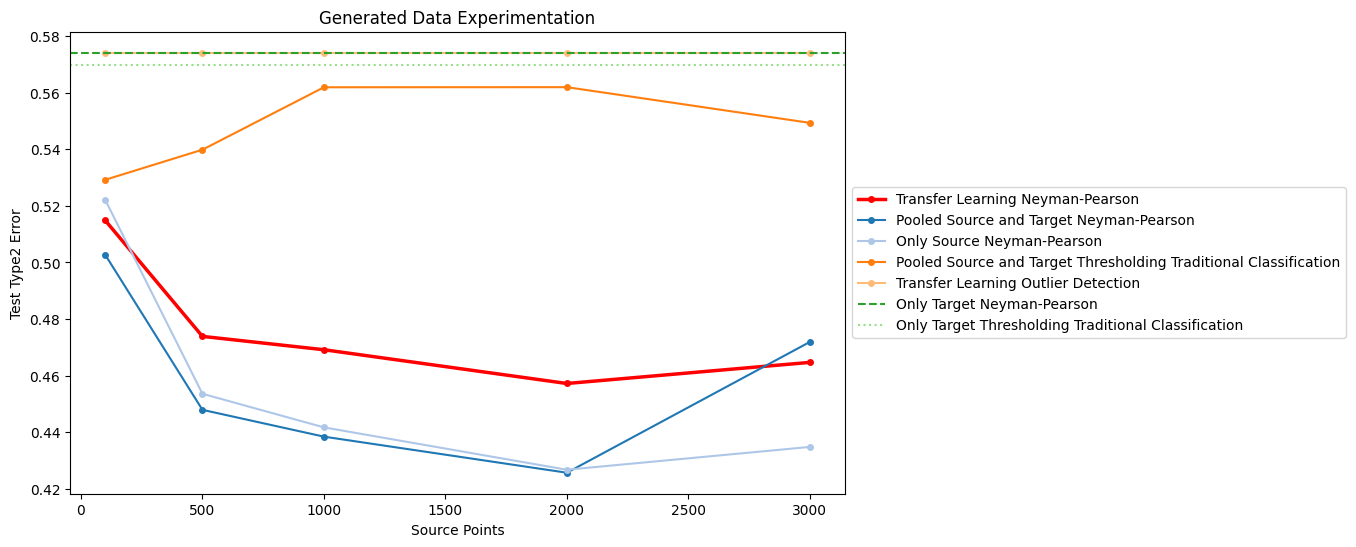

|    | Source Points   | Approach Type                                                    |   Best Lambda Source |   Best Lambda Normal |   Test Type1 Error |   Test Type2 Error |   Num Trainings |
|----|-----------------|------------------------------------------------------------------|----------------------|----------------------|--------------------|--------------------|-----------------|
|  0 | 100.0           | Only Source Neyman-Pearson                                       |                  0   |             54.6868  |            0.10352 |            0.52212 |            11.7 |
|  1 | 100.0           | Pooled Source and Target Neyman-Pearson                          |                  0   |             42.0825  |            0.10452 |            0.5027  |            11.1 |
|  2 | 100.0           | Pooled Source and Target Thresholding Traditional Classification |                nan   |            nan       |            0.10224 |            0.52924 |             1   |
|  3 | 100

In [59]:
config_name = 'config86_training_results'
path_pattern = os.path.join('results', config_name + '*.json')
graph_title = f'Generated Data Experimentation'
num_files = 10
process_experiment_results(path_pattern, num_files, graph_title)

# ClimSim Data Experimentation

## Data Preparation

### Importing ClimSim Rain Data

In [77]:
# Load the ClimSim Daily Data
start_time = time.time()

# Load the long/lat data
with open('data/climsim_data/location_lat_lon.csv', 'r') as f:
    location_dat = pd.read_csv(f)

if 'climsim_daily_data' not in globals():
    climsim_data_path = 'data/climsim_data/combined_daily_data_rain.csv'
    climsim_daily_data = pd.read_csv(climsim_data_path)

    # Remove data where rain_rate == 0
    climsim_daily_data = climsim_daily_data[climsim_daily_data['rain_rate'] != 0]

    # Create a new variable called rain_event that is 0 when rain is below the 95th percentile and 1 otherwise
    climsim_daily_data['rain_event'] = np.where(climsim_daily_data['rain_rate'] < np.percentile(climsim_daily_data['rain_rate'], 95), -1, 1)

    # Sort by latitude and then by longitude
    location_dat = location_dat.sort_values(by=['location']).reset_index(drop=True)

    # Divide locations into clusters
    location_dat['cluster_4'] = (location_dat.index // 4)
    location_dat['cluster_8'] = (location_dat.index // 8)
    location_dat['cluster_12'] = (location_dat.index // 12)
    location_dat['cluster_16'] = (location_dat.index // 16)

    # Add location cluster to dataframe
    climsim_daily_data = climsim_daily_data.merge(location_dat[['location', 'cluster_4', 'cluster_8', 'cluster_12', 'cluster_16']], on='location', how='left')

    print(f"Data loaded in {(time.time() - start_time)/60} minutes")
else:
    print("ClimSim Daily Data already loaded")

Data loaded in 1.037242046991984 minutes


### Data Processing Function

The following function is used during training to prepare the dataset based on the locations or clusters as target and source and the training/test split.

In [ ]:
def prepare_climsim_data(config, seed = None):
    """
    Prepares data for training and testing based on configuration.
    """
    # Set the random seed if provided
    if seed is not None:
        print(f"Setting data random seed to {seed}")
        random.seed(seed)

    # Check for supported data frequency
    if config["data_frequency"] != "daily":
        raise ValueError("Currently only 'daily' data_frequency is supported.")

    # Set target and source data based on config
    data_mode = config["data_mode"]
    target = config["targets"]
    source = config["sources"]

    # Use the specified column based on data_mode to filter target and source data
    column_name = 'rain_event'
    target_data = climsim_daily_data[climsim_daily_data[data_mode].isin(target)]
    source_data = climsim_daily_data[climsim_daily_data[data_mode].isin(source)]

    # Shuffle the data
    target_data = target_data.sample(frac=1, random_state=seed).reset_index(drop=True)
    source_data = source_data.sample(frac=1, random_state=seed).reset_index(drop=True)

    # Split into normal and abnormal datasets
    target_normal_data = target_data[target_data[column_name] == -1]
    target_abnormal_data = target_data[target_data[column_name] == 1]
    source_abnormal_data = source_data[source_data[column_name] == 1]

    # Validate configuration limits with detailed error messages
    if (config["num_target_normal_test"] + config["num_target_normal_training"] > len(target_normal_data)):
        raise ValueError(f"num_target_normal_training ({config['num_target_normal_training']}) + num_target_normal_test ({config['num_target_normal_test']}) cannot be greater than the number of target normal data points ({len(target_normal_data)}).")
    if (config["num_target_abnormal_test"] + config["num_target_abnormal_training"] > len(target_abnormal_data)):
        raise ValueError(f"num_target_abnormal_training ({config['num_target_abnormal_training']}) + num_target_abnormal_test ({config['num_target_abnormal_test']}) cannot be greater than the number of target abnormal data points ({len(target_abnormal_data)}).")
    if config["num_source_abnormal"] > len(source_abnormal_data):
        raise ValueError(f"num_source_abnormal ({config['num_source_abnormal']}) cannot be greater than the number of source abnormal data points ({len(source_abnormal_data)}).")

    # Train / Test split
    target_normal_train = target_normal_data[:config["num_target_normal_training"]]
    target_normal_test = target_normal_data[-config["num_target_normal_test"]:]
    target_abnormal_train = target_abnormal_data[:config["num_target_abnormal_training"]]
    target_abnormal_test = target_abnormal_data[-config["num_target_abnormal_test"]:]
    source_abnormal_train = source_abnormal_data[:config["num_source_abnormal"]]

    # Remove columns and convert to torch tensors
    columns_to_remove = ['date', 'location', 'cluster_4', 'cluster_8', 'cluster_12', 'cluster_16', 'rain_rate', 'snow_rate', 'rain_event', 'snow_event']
    input_dim = config.get('input_dim', 124)
    print(f"Using {input_dim} input features")

    # Drop specified columns and then randomly remove additional columns
    dataframes = [target_normal_train, target_abnormal_train, source_abnormal_train, target_normal_test, target_abnormal_test]
    dropped_dataframes = [df.drop(columns=[col for col in columns_to_remove if col in df.columns], errors='ignore') for df in dataframes]

    # Calculate number of random columns to remove and ensure same columns are removed across all
    num_columns_to_remove = dropped_dataframes[0].shape[1] - input_dim
    if num_columns_to_remove > 0:
        columns_to_randomly_remove = random.sample(list(dropped_dataframes[0].columns), num_columns_to_remove)
        dropped_dataframes = [df.drop(columns=columns_to_randomly_remove) for df in dropped_dataframes]

    # Convert to torch tensors
    target_normal_train_tensor, target_abnormal_train_tensor, source_abnormal_train_tensor, target_normal_test_tensor, target_abnormal_test_tensor = [
        torch.tensor(df.values, dtype=torch.float32) for df in dropped_dataframes
    ]

    # Print the number of data points in each dataset
    print(f"Number of data points in target_normal_train: {len(target_normal_train_tensor)}")
    print(f"Number of data points in target_abnormal_train: {len(target_abnormal_train_tensor)}")
    print(f"Number of data points in source_abnormal_train: {len(source_abnormal_train_tensor)}")
    print(f"Number of data points in target_normal_test: {len(target_normal_test_tensor)}")
    print(f"Number of data points in target_abnormal_test: {len(target_abnormal_test_tensor)}")

    return target_normal_train_tensor, target_abnormal_train_tensor, source_abnormal_train_tensor, target_normal_test_tensor, target_abnormal_test_tensor


## Location Visualization

The following section visualizing the locations and clusters in the ClimSim dataset.

### Map of Locations:

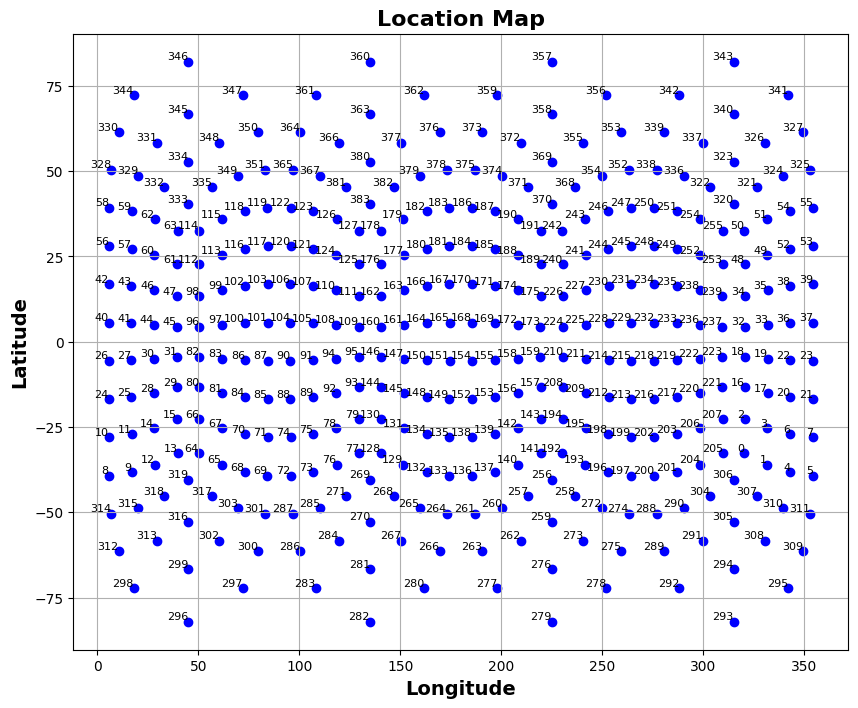

In [80]:
def plot_location_map(location_dat):
    # Show points on a grid of lat/lon
    locations = location_dat['location']
    latitudes = location_dat['latitude']
    longitudes = location_dat['longitude']
    plt.figure(figsize=(10, 8))
    plt.scatter(longitudes, latitudes, c='blue', marker='o')
    for location, lat, lon in zip(locations, latitudes, longitudes):
        plt.text(lon, lat, str(location), fontsize=8, ha='right', va='bottom')

    plt.title('Location Map', fontsize=16, fontweight='bold')
    plt.xlabel('Longitude', fontsize=14, fontweight='bold')
    plt.ylabel('Latitude', fontsize=14, fontweight='bold')
    plt.grid(True)

    # Show plot
    plt.show()

plot_location_map(location_dat)

### Clusters of 4 - Rain Data:

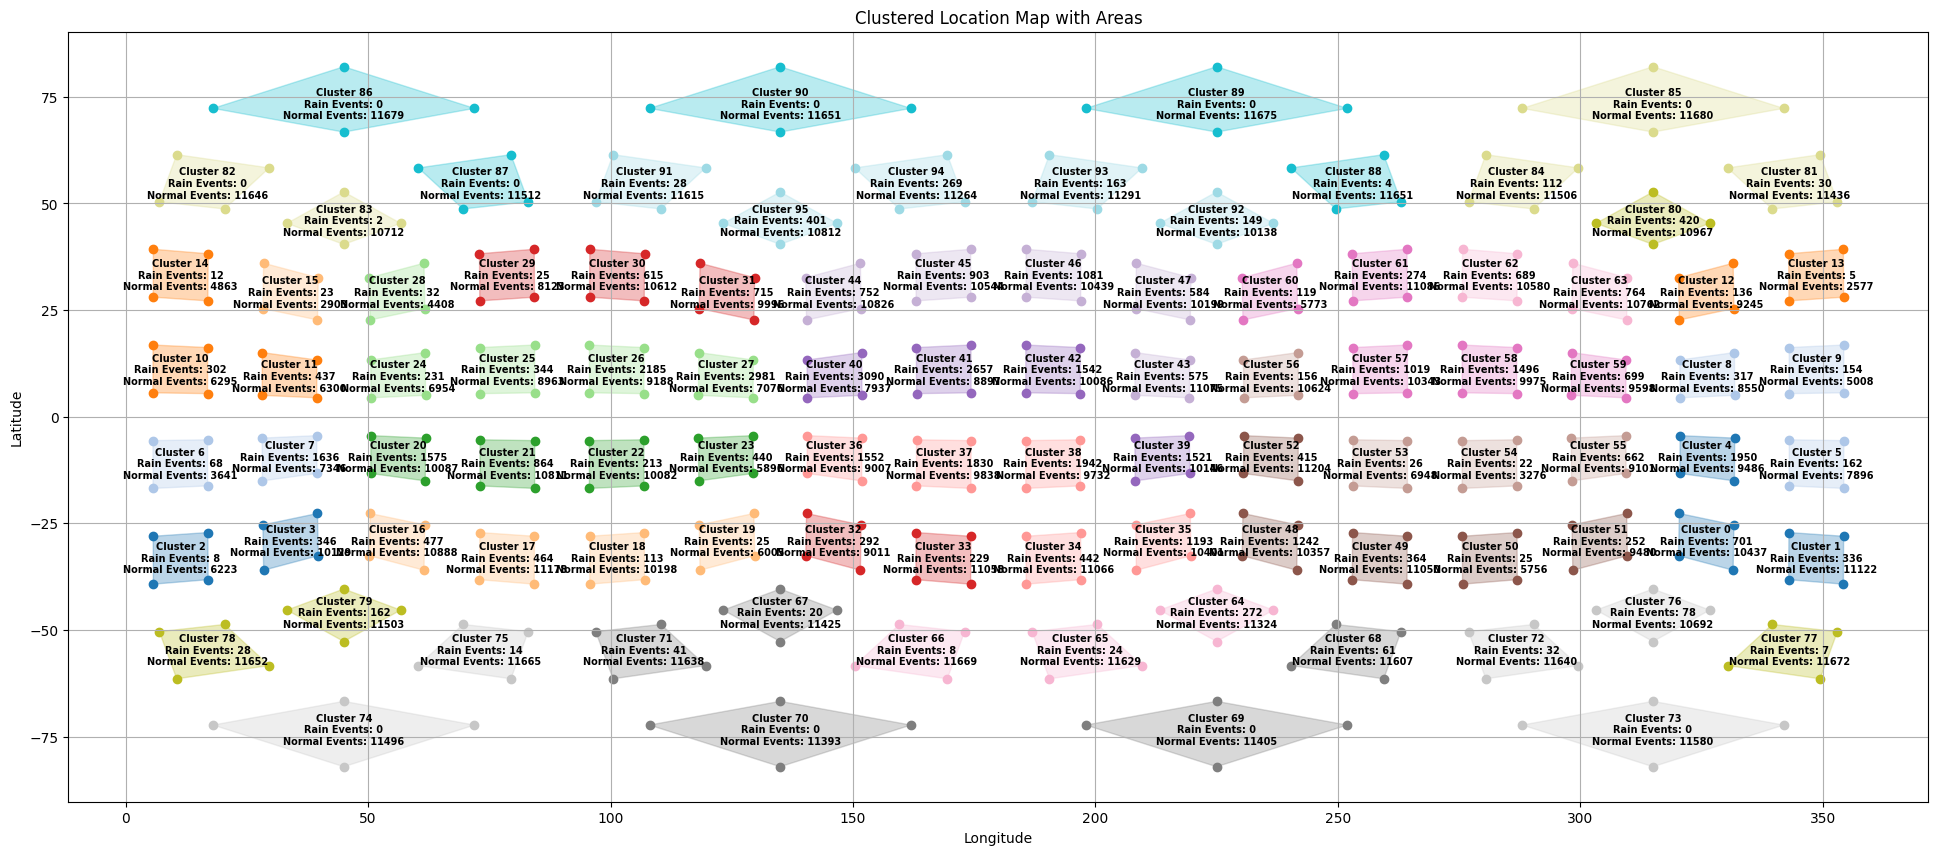

In [85]:
# Plotting the clustered points with filled areas
plt.figure(figsize=(24, 10))

num_clusters = 96
colors = plt.get_cmap('tab20', num_clusters)

for cluster in (location_dat['cluster_4'].unique()):
    cluster_points = location_dat[location_dat['cluster_4'] == cluster]
    points = cluster_points[['longitude', 'latitude']].values

    if len(points) >= 3:  # ConvexHull requires at least 3 points
        hull = ConvexHull(points)
        hull_points = np.append(hull.vertices, hull.vertices[0])
        plt.fill(points[hull_points, 0], points[hull_points, 1], color=colors(cluster), alpha=0.3)

        # Calculate the centroid of the cluster
        centroid = np.mean(points, axis=0)

        # Calculate the number of rain events in the cluster
        num_rain_events = len(climsim_daily_data[(climsim_daily_data['cluster_4'] == cluster) & (climsim_daily_data['rain_event'] == 1)])
        num_non_events = len(climsim_daily_data[(climsim_daily_data['cluster_4'] == cluster) & (climsim_daily_data['rain_event'] == -1)])

        # Display cluster number and number of rain events at the centroid
        plt.text(centroid[0], centroid[1], f'Cluster {cluster}\nRain Events: {num_rain_events}\nNormal Events: {num_non_events}', fontsize=7, ha='center', va='center', weight='bold')

    plt.scatter(cluster_points['longitude'], cluster_points['latitude'], label=f'Cluster {cluster}', color=colors(cluster))

# Set plot title and labels
plt.title('Clustered Location Map with Areas')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)

# Show plot
plt.show()

### Clusters of 8 - Rain Data:

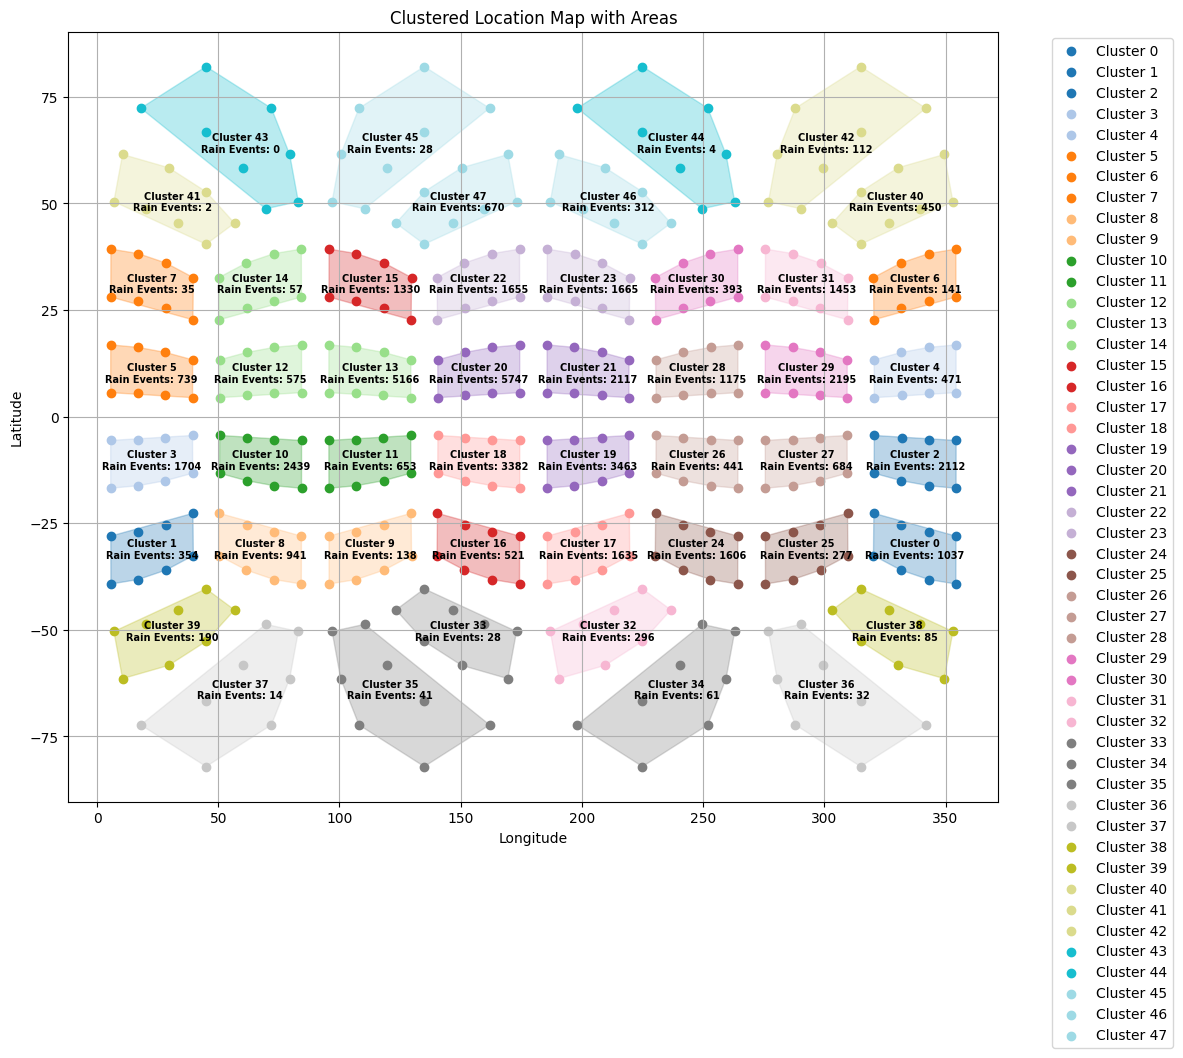

In [86]:
# Plotting the clustered points with filled areas
plt.figure(figsize=(12, 10))

num_clusters = 48
colors = plt.get_cmap('tab20', num_clusters)

for cluster in range(num_clusters):
    cluster_points = location_dat[location_dat['cluster_8'] == cluster]
    points = cluster_points[['longitude', 'latitude']].values

    if len(points) >= 3:  # ConvexHull requires at least 3 points
        hull = ConvexHull(points)
        hull_points = np.append(hull.vertices, hull.vertices[0])
        plt.fill(points[hull_points, 0], points[hull_points, 1], color=colors(cluster), alpha=0.3)

        # Calculate the centroid of the cluster
        centroid = np.mean(points, axis=0)

        # Calculate the number of rain events in the cluster
        num_rain_events = len(climsim_daily_data[(climsim_daily_data['cluster_8'] == cluster) & (climsim_daily_data['rain_event'] == 1)])

        # Display cluster number and number of rain events at the centroid
        plt.text(centroid[0], centroid[1], f'Cluster {cluster}\nRain Events: {num_rain_events}', fontsize=7, ha='center', va='center', weight='bold')

    plt.scatter(cluster_points['longitude'], cluster_points['latitude'], label=f'Cluster {cluster}', color=colors(cluster))

# Set plot title and labels
plt.title('Clustered Location Map with Areas')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.show()

## Experimentation

In [ ]:
config_paths = ['configs/config_climsim_snow_6.json']

for config_path in config_paths:

    with open(config_path, 'r') as file:
        config = json.load(file)

    debug_modes = {
      'print_training_progress': False,
      'print_lr_changes': False,
      'show_losses_graphs': False,
      'show_lr_changes': False,
      'print_increment_updates': False,
      'print_point_selection': True
    }

    # Define model, optimizer, scheduler, loss function
    model_config = config["model_config"]
    model = get_model(model_config)
    model_parameters = model.parameters()
    optimizer_config = config["optimizer_config"]
    optimizer = get_optimizer(optimizer_config, model_parameters)
    scheduler_config = config["scheduler_config"]
    scheduler = get_scheduler(scheduler_config, optimizer)

    # Training config
    training_config = config["training_config"]
    loss_function = get_loss_function(training_config["loss_function"])

    # Data generation config
    climsim_config = config["climsim_config"]
    num_source_points_list = config["num_source_points_list"]
    seeds = config["seeds"]

    for i, seed in zip(range(len(seeds)),seeds):

        # Prepare data
        target_normal_train, target_abnormal_train, source_abnormal_train, target_normal_test, target_abnormal_test = prepare_climsim_data(climsim_config, seed)

        # Run experiment iteration
        run_experiment_iteration(i, seed, model, optimizer, scheduler, loss_function, training_config, debug_modes,
                                target_normal_train, target_normal_test, target_abnormal_train, target_abnormal_test,
                                source_abnormal_train, num_source_points_list, config_path, config)

## Results Analysis

Number of files found: 10


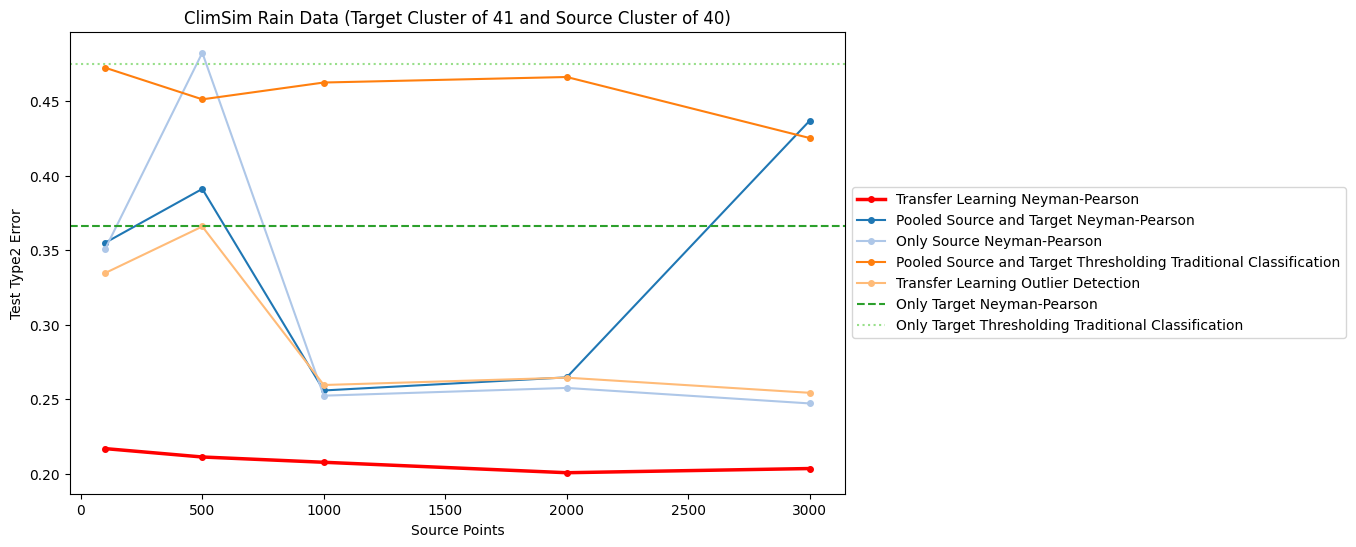

|    | Source Points   | Approach Type                                                    |   Best Lambda Source |   Best Lambda Normal |   Test Type1 Error |   Test Type2 Error |   Num Trainings |
|----|-----------------|------------------------------------------------------------------|----------------------|----------------------|--------------------|--------------------|-----------------|
|  0 | 100.0           | Only Source Neyman-Pearson                                       |                    0 |            321.283   |          0.0263427 |           0.350674 |            14.1 |
|  1 | 100.0           | Pooled Source and Target Neyman-Pearson                          |                    0 |            239.714   |          0.0215846 |           0.35491  |            11.6 |
|  2 | 100.0           | Pooled Source and Target Thresholding Traditional Classification |                  nan |            nan       |          0.0258934 |           0.472353 |             1   |
|  3 | 100

In [ ]:
config_name = 'config_climsim_44_training_results'
path_pattern = os.path.join('results', config_name + '*.json')
graph_title = f'ClimSim Rain Data (Target Cluster of 41 and Source Cluster of 40)'
num_files = 10
process_experiment_results(path_pattern, num_files, graph_title)

Number of files found: 10


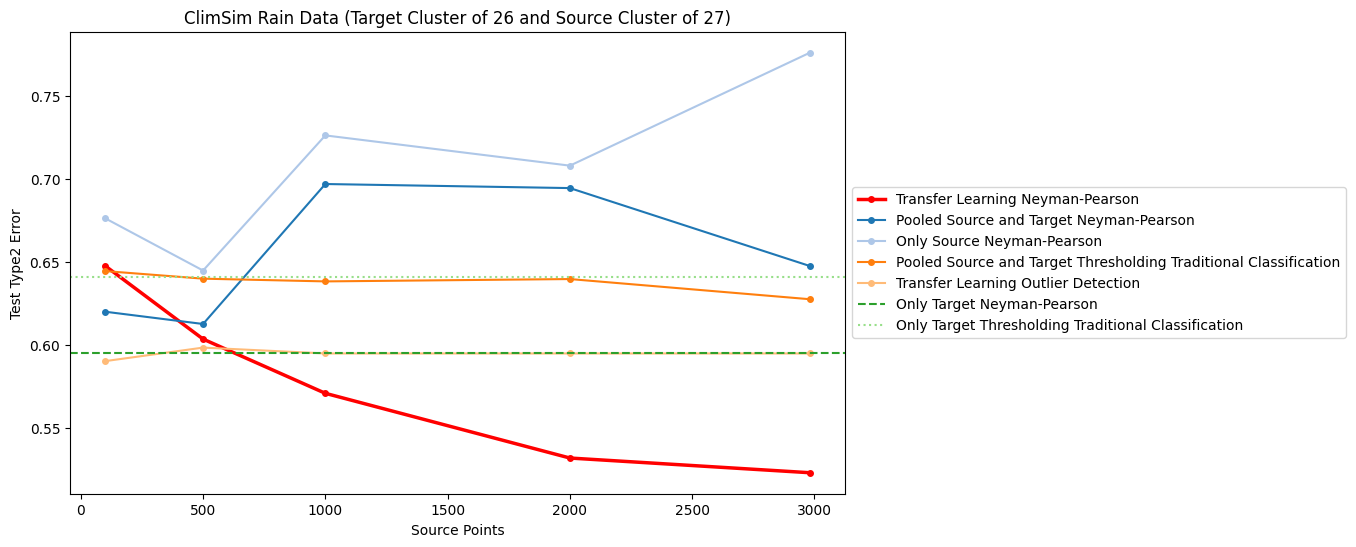

|    | Source Points   | Approach Type                                                    |   Best Lambda Source |   Best Lambda Normal |   Test Type1 Error |   Test Type2 Error |   Num Trainings |
|----|-----------------|------------------------------------------------------------------|----------------------|----------------------|--------------------|--------------------|-----------------|
|  0 | 100.0           | Only Source Neyman-Pearson                                       |                  0   |            334.95    |            0.02772 |           0.676424 |            12.5 |
|  1 | 100.0           | Pooled Source and Target Neyman-Pearson                          |                  0   |            309.137   |            0.02506 |           0.620188 |            14.2 |
|  2 | 100.0           | Pooled Source and Target Thresholding Traditional Classification |                nan   |            nan       |            0.02416 |           0.644659 |             1   |
|  3 | 100

In [73]:
config_name = 'config_climsim_45_training_results'
path_pattern = os.path.join('results', config_name + '*.json')
graph_title = f'ClimSim Rain Data (Target Cluster of 26 and Source Cluster of 27)'
num_files = 10
process_experiment_results(path_pattern, num_files, graph_title)

Number of files found: 10


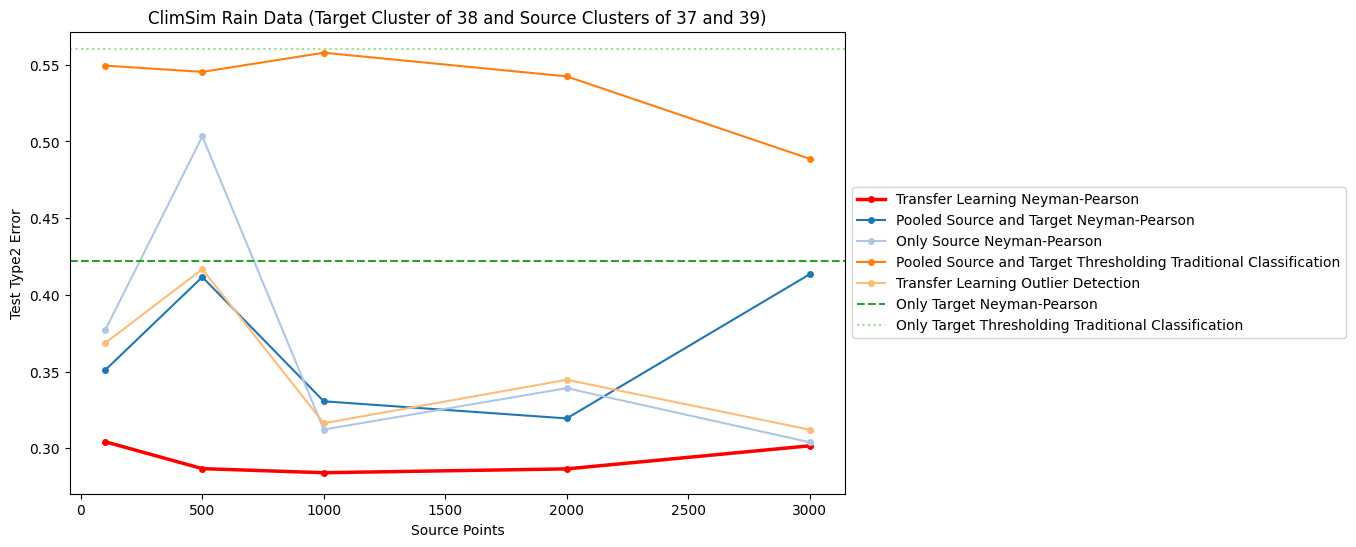

|    | Source Points   | Approach Type                                                    |   Best Lambda Source |   Best Lambda Normal |   Test Type1 Error |   Test Type2 Error |   Num Trainings |
|----|-----------------|------------------------------------------------------------------|----------------------|----------------------|--------------------|--------------------|-----------------|
|  0 | 100.0           | Only Source Neyman-Pearson                                       |                  0   |            255.864   |            0.02712 |           0.376939 |            12.5 |
|  1 | 100.0           | Pooled Source and Target Neyman-Pearson                          |                  0   |            162.91    |            0.02812 |           0.350956 |            13.3 |
|  2 | 100.0           | Pooled Source and Target Thresholding Traditional Classification |                nan   |            nan       |            0.02414 |           0.549416 |             1   |
|  3 | 100

In [74]:
config_name = 'config_climsim_46_training_results'
path_pattern = os.path.join('results', config_name + '*.json')
graph_title = f'ClimSim Rain Data (Target Cluster of 38 and Source Clusters of 37 and 39)'
num_files = 10
process_experiment_results(path_pattern, num_files, graph_title)

Number of files found: 10


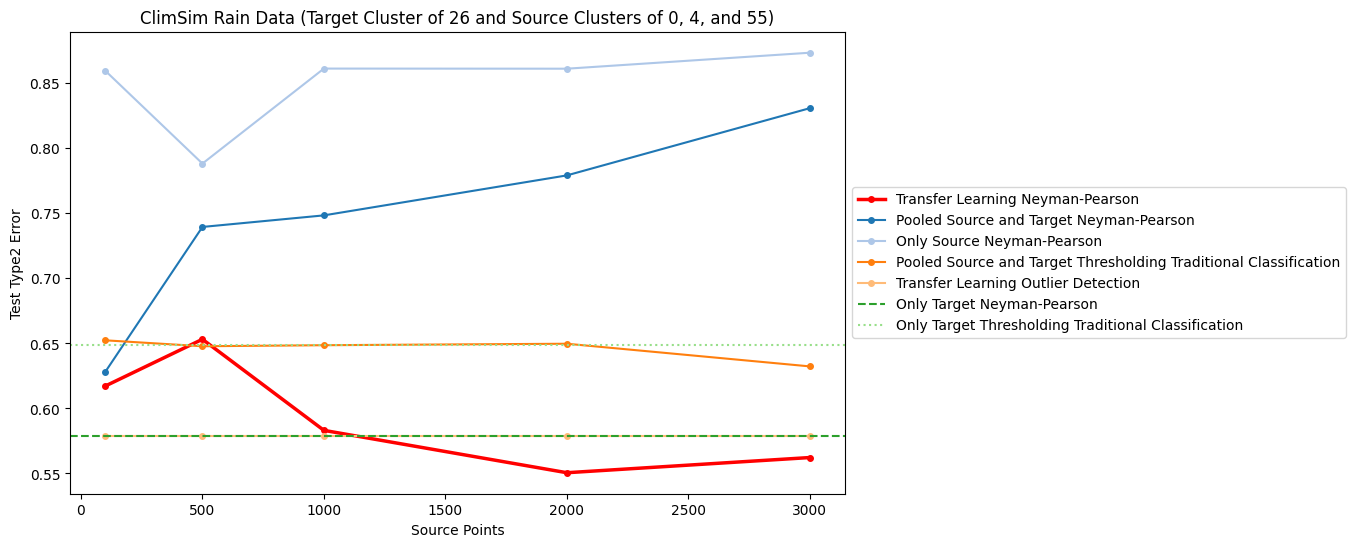

|    | Source Points   | Approach Type                                                    |   Best Lambda Source |   Best Lambda Normal |   Test Type1 Error |   Test Type2 Error |   Num Trainings |
|----|-----------------|------------------------------------------------------------------|----------------------|----------------------|--------------------|--------------------|-----------------|
|  0 | 100.0           | Only Source Neyman-Pearson                                       |                  0   |              54.0095 |            0.03034 |           0.859624 |             8.7 |
|  1 | 100.0           | Pooled Source and Target Neyman-Pearson                          |                  0   |             219.642  |            0.02318 |           0.628094 |            12.4 |
|  2 | 100.0           | Pooled Source and Target Thresholding Traditional Classification |                nan   |             nan      |            0.02474 |           0.652376 |             1   |
|  3 | 100

In [75]:
config_name = 'config_climsim_47_training_results'
path_pattern = os.path.join('results', config_name + '*.json')
graph_title = f'ClimSim Rain Data (Target Cluster of 26 and Source Clusters of 0, 4, and 55)'
num_files = 10
process_experiment_results(path_pattern, num_files, graph_title)

Number of files found: 10


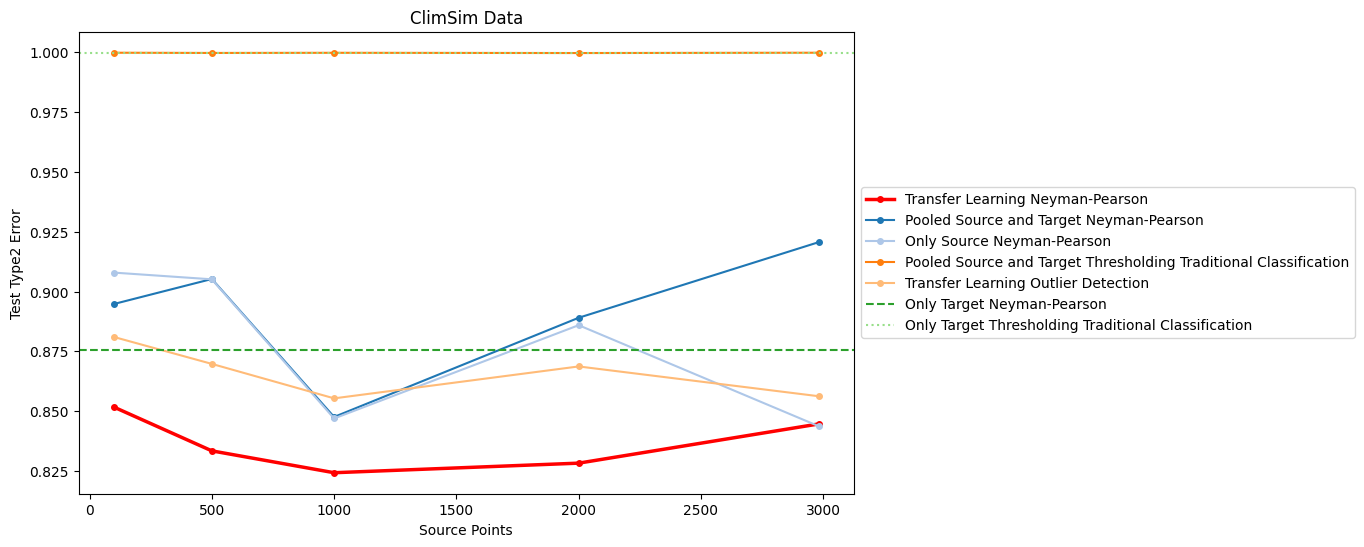

|    | Source Points   | Approach Type                                                    |   Best Lambda Source |   Best Lambda Normal |   Test Type1 Error |   Test Type2 Error |   Num Trainings |
|----|-----------------|------------------------------------------------------------------|----------------------|----------------------|--------------------|--------------------|-----------------|
|  0 | 100.0           | Only Source Neyman-Pearson                                       |                    0 |           123.757    |            0.02138 |           0.9079   |            18.7 |
|  1 | 100.0           | Pooled Source and Target Neyman-Pearson                          |                    0 |            93.3689   |            0.02524 |           0.8948   |            18.6 |
|  2 | 100.0           | Pooled Source and Target Thresholding Traditional Classification |                  nan |           nan        |            0.02474 |           0.999767 |             1   |
|  3 | 100

In [92]:
config_name = 'config_climsim_snow_6_training_results'
path_pattern = os.path.join('results', config_name + '*.json')
graph_title = f'ClimSim Data'
num_files = 10
process_experiment_results(path_pattern, num_files, graph_title)

# Give Me Some Credit Data Experimentation

## Data Preparation

### Importing Dataset

In [ ]:
# Load the CSV files and ignore the index column (first column)
train_file_path = r'data\give_me_some_credit\cs-training.csv'
test_file_path = r'data\give_me_some_credit\cs-test.csv'

train_data = pd.read_csv(train_file_path, index_col=0)
test_data = pd.read_csv(test_file_path, index_col=0)

# Combine the two DataFrames using pd.concat()
credit_data = pd.concat([train_data, test_data], ignore_index=True)

# Remove row with age==0
credit_data = credit_data[credit_data['age'] != 0]
credit_data = credit_data.dropna()

# Print the shape of the combined DataFrame to confirm
print(f"Combined data shape: {credit_data.shape}")

### Data Processing Function

In [ ]:
def split_data(data, min_age, max_age):
    data = data[data['age'] <= max_age]
    data = data[data['age'] >= min_age]

    # Split the DataFrame based on SeriousDlqin2yrs == 0 or 1
    normal_data = data[data['SeriousDlqin2yrs'] == 0]
    abnormal_data = data[data['SeriousDlqin2yrs'] == 1]

    # Drop the 'SeriousDlqin2yrs' and 'age' columns from both DataFrames if you don't need it in the tensors
    normal_data = normal_data.drop(columns=['SeriousDlqin2yrs', 'age'])
    abnormal_data = abnormal_data.drop(columns=['SeriousDlqin2yrs', 'age'])

    # Convert both DataFrames to PyTorch tensors
    normal_data = torch.tensor(normal_data.values, dtype=torch.float32)
    abnormal_data = torch.tensor(abnormal_data.values, dtype=torch.float32)

    return normal_data, abnormal_data

def prepare_credit_data(data, config, seed = None):
    # Set the random seed if provided
    if seed is not None:
        print(f"Setting data random seed to {seed}")
        random.seed(seed)

    target_min_age = config['target_min_age']
    target_max_age = config['target_max_age']
    target_normal_data, target_abnormal_data = split_data(data, target_min_age, target_max_age)

    source_min_age = config['source_min_age']
    source_max_age = config['source_max_age']
    source_normal_data, source_abnormal_data = split_data(data, source_min_age, source_max_age)

    # Shuffle the data
    target_normal_data = target_normal_data[torch.randperm(target_normal_data.size(0))]
    target_abnormal_data = target_abnormal_data[torch.randperm(target_abnormal_data.size(0))]
    source_normal_data = source_normal_data[torch.randperm(source_normal_data.size(0))]
    source_abnormal_data = source_abnormal_data[torch.randperm(source_abnormal_data.size(0))]

    # Validate configuration limits with detailed error messages
    if (config["num_target_normal_test"] + config["num_target_normal_training"] > len(target_normal_data)):
        raise ValueError(f"num_target_normal_training ({config['num_target_normal_training']}) + num_target_normal_test ({config['num_target_normal_test']}) cannot be greater than the number of target normal data points ({len(target_normal_data)}).")
    if (config["num_target_abnormal_test"] + config["num_target_abnormal_training"] > len(target_abnormal_data)):
        raise ValueError(f"num_target_abnormal_training ({config['num_target_abnormal_training']}) + num_target_abnormal_test ({config['num_target_abnormal_test']}) cannot be greater than the number of target abnormal data points ({len(target_abnormal_data)}).")
    if config["num_source_abnormal"] > len(source_abnormal_data):
        raise ValueError(f"num_source_abnormal ({config['num_source_abnormal']}) cannot be greater than the number of source abnormal data points ({len(source_abnormal_data)}).")

    # Train / Test split
    target_normal_train = target_normal_data[:config["num_target_normal_training"]]
    target_normal_test = target_normal_data[-config["num_target_normal_test"]:]
    target_abnormal_train = target_abnormal_data[:config["num_target_abnormal_training"]]
    target_abnormal_test = target_abnormal_data[-config["num_target_abnormal_test"]:]
    source_abnormal_train = source_abnormal_data[:config["num_source_abnormal"]]

    # Print the number of data points in each dataset
    print(f"Number of data points in target_normal_train: {len(target_normal_train)}")
    print(f"Number of data points in target_abnormal_train: {len(target_abnormal_train)}")
    print(f"Number of data points in source_abnormal_train: {len(source_abnormal_train)}")
    print(f"Number of data points in target_normal_test: {len(target_normal_test)}")
    print(f"Number of data points in target_abnormal_test: {len(target_abnormal_test)}")

    return target_normal_train, target_abnormal_train, source_abnormal_train, target_normal_test, target_abnormal_test


## Experimentation

In [ ]:
config_paths = ['configs/config_credit_1.json']

for config_path in config_paths:

    with open(config_path, 'r') as file:
        config = json.load(file)

    verbose_training=False
    debug_modes = {
      'print_training_progress': False,
      'print_lr_changes': False,
      'show_losses_graphs': False,
      'show_lr_changes': False,
      'log_scale': True,
      'print_increment_updates': False,
      'print_point_selection': True
    }

    # Define model, optimizer, scheduler, loss function
    model_config = config["model_config"]
    model = get_model(model_config)
    model_parameters = model.parameters()
    optimizer_config = config["optimizer_config"]
    optimizer = get_optimizer(optimizer_config, model_parameters)
    scheduler_config = config["scheduler_config"]
    scheduler = get_scheduler(scheduler_config, optimizer)

    # Training config
    training_config = config["training_config"]
    loss_function = get_loss_function(training_config["loss_function"])

    # Data generation config
    credit_config = config["credit_config"]
    num_source_points_list = config["num_source_points_list"]
    seeds = config["seeds"]

    for i, seed in zip(range(len(seeds)),seeds):

        # Prepare data
        target_normal_train, target_abnormal_train, source_abnormal_train, target_normal_test, target_abnormal_test = prepare_credit_data(credit_data, credit_config, seed)

        # Run experiment iteration
        run_experiment_iteration(i, seed, model, optimizer, scheduler, loss_function, training_config, debug_modes,
                                target_normal_train, target_normal_test, target_abnormal_train, target_abnormal_test,
                                source_abnormal_train, num_source_points_list, config_path, config)

## Results Analysis

Number of files found: 10


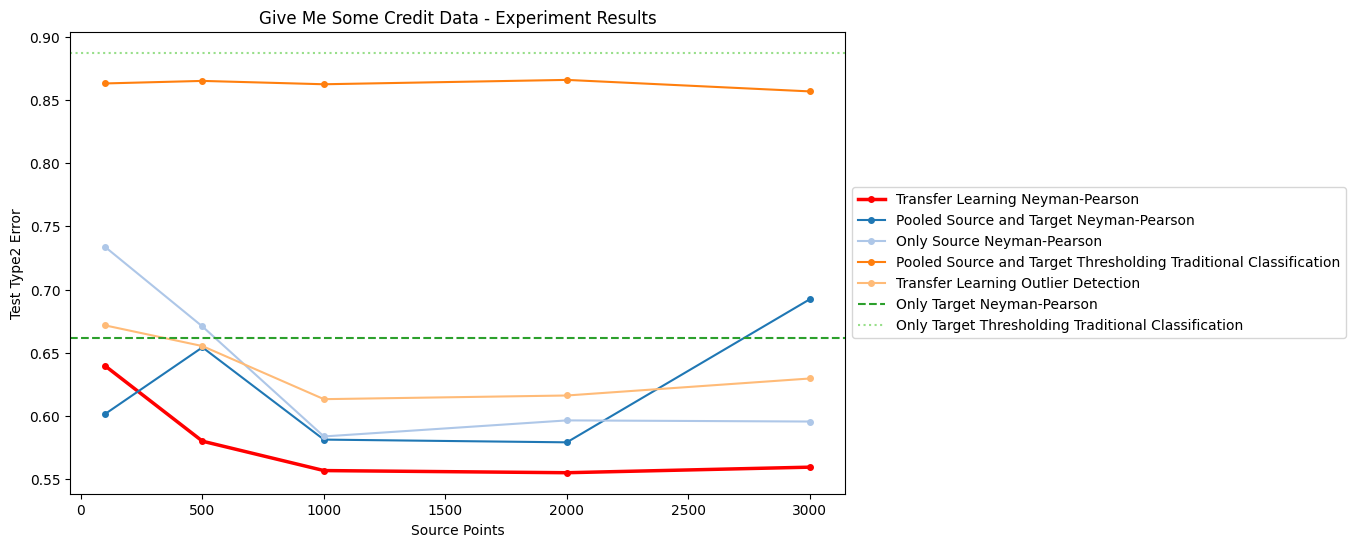

|    | Source Points   | Approach Type                                                    |   Best Lambda Source |   Best Lambda Normal |   Test Type1 Error |   Test Type2 Error |   Num Trainings |
|----|-----------------|------------------------------------------------------------------|----------------------|----------------------|--------------------|--------------------|-----------------|
|  0 | 100.0           | Only Source Neyman-Pearson                                       |                    0 |             62.0031  |            0.09774 |            0.73365 |            22.7 |
|  1 | 100.0           | Pooled Source and Target Neyman-Pearson                          |                    0 |             34.7436  |            0.102   |            0.60165 |            15.9 |
|  2 | 100.0           | Pooled Source and Target Thresholding Traditional Classification |                  nan |            nan       |            0.10096 |            0.8631  |             1   |
|  3 | 100

In [57]:
config_name = 'config_credit_1'
path_pattern = os.path.join('results', config_name + '*.json')
graph_title = 'Give Me Some Credit Data - Experiment Results'
num_files = 10
process_experiment_results(path_pattern, num_files, graph_title)

# NASA Data Experimentation

## Data Preparation

### Data Processing Functions

In [42]:
def load_nasa_data(target_path, source_path):

    # Load the NASA Daily Data
    start_time = time.time()

    # Load the long/lat data
    with open(target_path, 'r') as f:
        target_dat = pd.read_csv(f)

    with open(source_path, 'r') as f:
        source_dat = pd.read_csv(f)

    print(f"Data loaded in {(time.time() - start_time)/60} minutes")

    return target_dat, source_dat

def prepare_nasa_data(config, seed=None):
    """
    Prepares data for training and testing based on configuration.
    """
    # Set the random seed if provided
    if seed is not None:
        print(f"Setting data random seed to {seed}")
        random.seed(seed)

    # Load data
    target_path = config["target_path"]
    source_path = config["source_path"]
    target_data, source_data = load_nasa_data(target_path, source_path)

    # Shuffle the data
    target_data = target_data.sample(frac=1, random_state=seed).reset_index(drop=True)
    source_data = source_data.sample(frac=1, random_state=seed).reset_index(drop=True)

    # Split into normal and abnormal datasets
    target_normal_data = target_data[target_data['rain_label'] == 0]
    target_abnormal_data = target_data[target_data['rain_label'] == 1]
    source_abnormal_data = source_data[source_data['rain_label'] == 1]

    # Validate configuration limits with detailed error messages
    if (config["num_target_normal_test"] + config["num_target_normal_training"] > len(target_normal_data)):
        raise ValueError(f"num_target_normal_training ({config['num_target_normal_training']}) + num_target_normal_test ({config['num_target_normal_test']}) cannot be greater than the number of target normal data points ({len(target_normal_data)}).")
    if (config["num_target_abnormal_test"] + config["num_target_abnormal_training"] > len(target_abnormal_data)):
        raise ValueError(f"num_target_abnormal_training ({config['num_target_abnormal_training']}) + num_target_abnormal_test ({config['num_target_abnormal_test']}) cannot be greater than the number of target abnormal data points ({len(target_abnormal_data)}).")
    if config["num_source_abnormal"] > len(source_abnormal_data):
        raise ValueError(f"num_source_abnormal ({config['num_source_abnormal']}) cannot be greater than the number of source abnormal data points ({len(source_abnormal_data)}).")

    # Train / Test split
    target_normal_train = target_normal_data[:config["num_target_normal_training"]]
    target_normal_test = target_normal_data[-config["num_target_normal_test"]:]
    target_abnormal_train = target_abnormal_data[:config["num_target_abnormal_training"]]
    target_abnormal_test = target_abnormal_data[-config["num_target_abnormal_test"]:]
    source_abnormal_train = source_abnormal_data[:config["num_source_abnormal"]]

    # Convert to torch tensors
    columns_to_remove = ['rain_label']
    target_normal_train_tensor = torch.tensor(target_normal_train.drop(columns=columns_to_remove, errors='ignore').values, dtype=torch.float32)
    target_abnormal_train_tensor = torch.tensor(target_abnormal_train.drop(columns=columns_to_remove, errors='ignore').values, dtype=torch.float32)
    source_abnormal_train_tensor = torch.tensor(source_abnormal_train.drop(columns=columns_to_remove, errors='ignore').values, dtype=torch.float32)
    target_normal_test_tensor = torch.tensor(target_normal_test.drop(columns=columns_to_remove, errors='ignore').values, dtype=torch.float32)
    target_abnormal_test_tensor = torch.tensor(target_abnormal_test.drop(columns=columns_to_remove, errors='ignore').values, dtype=torch.float32)

    # Print the number of data points in each dataset
    print(f"Number of data points in target_normal_train: {len(target_normal_train_tensor)}")
    print(f"Number of data points in target_abnormal_train: {len(target_abnormal_train_tensor)}")
    print(f"Number of data points in source_abnormal_train: {len(source_abnormal_train_tensor)}")
    print(f"Number of data points in target_normal_test: {len(target_normal_test_tensor)}")
    print(f"Number of data points in target_abnormal_test: {len(target_abnormal_test_tensor)}")

    return target_normal_train_tensor, target_abnormal_train_tensor, source_abnormal_train_tensor, target_normal_test_tensor, target_abnormal_test_tensor

## Experimentation

In [90]:
config_path = 'configs/config_nasa_4.json'

with open(config_path, 'r') as file:
    config = json.load(file)

verbose_training=False
debug_modes = {
  'print_training_progress': False,
  'print_lr_changes': False,
  'show_losses_graphs': False,
  'show_lr_changes': False,
  'print_increment_updates': False,
  'print_point_selection': True
}

# Define model, optimizer, scheduler, loss function
model_config = config["model_config"]
model = get_model(model_config)
model_parameters = model.parameters()
optimizer_config = config["optimizer_config"]
optimizer = get_optimizer(optimizer_config, model_parameters)
scheduler_config = config["scheduler_config"]
scheduler = get_scheduler(scheduler_config, optimizer)

# Training config
training_config = config["training_config"]
loss_function = get_loss_function(training_config["loss_function"])

# Data generation config
nasa_config = config["nasa_config"]
num_source_points_list = config["num_source_points_list"]
seeds = config["seeds"]

for i, seed in zip(range(len(seeds)),seeds):

    # Randomize data
    target_normal_train, target_abnormal_train, source_abnormal_train, target_normal_test, target_abnormal_test = prepare_nasa_data(nasa_config, seed)

    run_experiment_iteration(i, seed, model, optimizer, scheduler, loss_function, training_config, debug_modes,
                             target_normal_train, target_normal_test, target_abnormal_train, target_abnormal_test,
                             source_abnormal_train, num_source_points_list, config_path, config)

Setting data random seed to 10
Data loaded in 0.003237342834472656 minutes
Number of data points in target_normal_train: 4000
Number of data points in target_abnormal_train: 60
Number of data points in source_abnormal_train: 3000
Number of data points in target_normal_test: 5000
Number of data points in target_abnormal_test: 2000

╔══════════════════════════════════════════════════════════════════════════════════════════════════╗
║                                                                                                  ║
║                         STARTING EXPERIMENT ITERATION #1 WITH SEED OF 10                         ║
║                                                                                                  ║
╚══════════════════════════════════════════════════════════════════════════════════════════════════╝


────────────────────────────────────────────────────────────────────────────────────────────────────
Running Only Target Neyman-Pearson...
─────────────────────

KeyboardInterrupt: 

## Results Analysis

Number of files found: 10


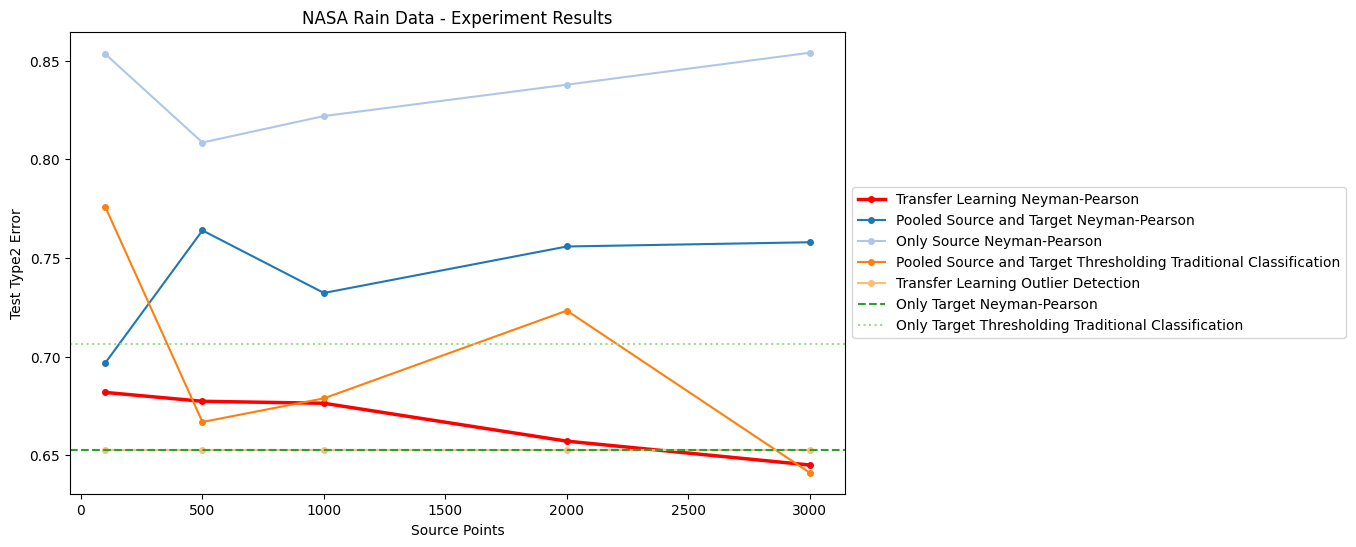

|    | Source Points   | Approach Type                                                    |   Best Lambda Source |   Best Lambda Normal |   Test Type1 Error |   Test Type2 Error |   Num Trainings |
|----|-----------------|------------------------------------------------------------------|----------------------|----------------------|--------------------|--------------------|-----------------|
|  0 | 100.0           | Only Source Neyman-Pearson                                       |                  0   |             4.6381   |            0.02808 |            0.85335 |             4.9 |
|  1 | 100.0           | Pooled Source and Target Neyman-Pearson                          |                  0   |           150.93     |            0.0278  |            0.69675 |            11.3 |
|  2 | 100.0           | Pooled Source and Target Thresholding Traditional Classification |                nan   |           nan        |            0.02426 |            0.7759  |             1   |
|  3 | 100

In [49]:
config_name = 'config_nasa_4'
path_pattern = os.path.join('results', config_name + '*.json')
graph_title = 'NASA Rain Data - Experiment Results'
num_files = 10
process_experiment_results(path_pattern, num_files, graph_title, 0.0329)